
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    `Yue Peng`

**Student ID(s):**     `958289`

**Student Name(s):**    `Tian Qiu`

**Student ID(s):**     `988121`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
import math
import operator
from collections import defaultdict
from functools import reduce
import random

In [2]:
"""The class to calculate the prior probability of each class.
"""
class ClassCounter:
    def __init__(self, subject):
        self.subject = subject #the subject name

    #initialize memory space
    def prepare(self, class_num):
        self.__classes_count = [0] * class_num #number of each class
        self.__classes_prob = [0] * class_num #the probability of each class
        
    #count the number of each class
    def add(self, class_index):
        self.__classes_count[class_index] += 1
    
    #calculate the probability
    def run(self):
        total = sum(self.__classes_count)
        for index, val in enumerate(self.__classes_count):
            self.__classes_prob[index] = val/total
    
    #return the probability of each class as a tuple
    def get(self):
        return tuple(self.__classes_prob)
    
    def get_classes_count(self):
        #return how many elements are there in each class
        return self.__classes_count
    
"""The parent class to calculate the conditional probability of each attribute
   given each class.
"""
class AttrCounter:
    def __init__(self, name):
        self.name = name #the name of the attribute 

    #initialize memory space
    def prepare(self, class_num):
        pass
    
    #record the attribute value under the class
    def add(self, attr, class_index):
        pass 
    
    #calculate the probability
    def run(self):
        pass 
    
    #return the probability of the given attribute value under each class as a tuple
    def get(self, attr):
        pass
    
    #draw chart to show the value distribution of each class
    def draw_distribution(self, classes):
        pass
    
"""The class to calculate the conditional probability of nominal attribute
   given each class.
"""
class NomCounter(AttrCounter):
    __smooth_alpha = 1
    
    def __init__(self, name):
        super().__init__(name)

    def prepare(self, class_num):
        self._attr_vals = set() #all possible values of this attribute
        self._attr_count = [defaultdict(int) for i in range(class_num)] #for each class values,the numbers of this attribute values
        self._attr_prob = [defaultdict(float) for i in range(class_num)] #for each class values,the probability of this attribute values
    
    def add(self, attr, class_index):
        #add the attribute values
        self._attr_vals.add(attr)
        #add the number of attribute value in corresponding class
        self._attr_count[class_index][attr] += 1
    
    def run(self):
        #number of all possible attribute values in the dataset
        dimension = len(self._attr_vals)
        #to calculate the probability of each attribute value precentage in this particular class
        for class_index, attrs in enumerate(self._attr_count):
            total = sum(attrs.values())
            for val in self._attr_vals:
                self._attr_prob[class_index][val] = self._laplace_smooth(attrs[val], total, dimension)
    
    def get(self, attr): 
        return tuple(prob[attr] for prob in self._attr_prob)
    
    def draw_distribution(self, classes):
        x = range(len(self._attr_vals))
        for class_index,classname in enumerate(classes):
            plt.figure(figsize=(10,6), dpi=80)
            plt.bar(x, [self._attr_count[class_index][val] for val in self._attr_vals], width=0.1)
            plt.xticks(x, self._attr_vals, rotation=0 if len(self._attr_vals)<8 else 90)
            
            plt.title(classname, fontsize=14)
            plt.xlabel(self.name, fontsize=14)
            plt.ylabel('Instance Number', fontsize=14)
            plt.show()
    
    #Laplace smoothing method
    def _laplace_smooth(self, num, total, dimension):
        return (num+self.__smooth_alpha)/(total+dimension*self.__smooth_alpha)
    
"""The class to calculate the conditional probability of numeric attribute
   given each class.
"""
class NumCounter(AttrCounter):    
    def __init__(self, name):
        super().__init__(name)

    def prepare(self, class_num):
        self._attr_data = [[] for i in range(class_num)] #for each class, store the corresponding attribute values
        self._mean = [0] * class_num #for each class,calculate the mean of this attribute
        self._deviation = [0] * class_num #for each class, the standard deviation of this attribute
    
    def add(self, attr, class_index):
        #to store all the values into the container
        self._attr_data[class_index].append(float(attr))
    
    def run(self):
        #use the values that stored in the container to calculate the mean values and deviation values for each class
        for class_index, data in enumerate(self._attr_data):
            mean = sum(data)/len(data)
            deviation = math.sqrt(sum([(x - mean)**2 for x in data])/(len(data)-1))
            self._mean[class_index] = mean
            self._deviation[class_index] = deviation
    
    def get(self, attr):
        return tuple(self._normal_distribution(float(attr), self._mean[i], self._deviation[i]) for i in range(len(self._mean)))
    
    #calculate pdf of normal distribution
    def _normal_distribution(self, val, mean, deviation):
        res = 1/(deviation*math.sqrt(2*math.pi))*np.exp(-((val-mean)/deviation)**2/2) if deviation > 0 else 0
        return res if res > sys.float_info.min else sys.float_info.min
    
    def draw_distribution(self, classes):
        all_data = set(reduce(operator.add, self._attr_data))
        min_val = min(all_data)
        max_val = max(all_data)
        bin_size = 20
        for class_index,classname in enumerate(classes):
            plt.figure(figsize=(14,6), dpi=80)
            plt.subplot(121)
            plt.title(classname, fontsize=14)
            plt.hist(self._attr_data[class_index], bins = bin_size, range=(min_val, max_val), color = 'g', edgecolor = 'k')
            plt.xlabel(self.name, fontsize=14)
            plt.ylabel('Instance Number', fontsize=14)
            plt.subplot(122)
            plt.title(classname, fontsize=14)
            x = np.linspace(min_val,max_val,100)
            y = [self._normal_distribution(t, self._mean[class_index], self._deviation[class_index]) for t in x]
            plt.plot(x, y, color = 'g')
            plt.xlabel(self.name, fontsize=14)
            plt.ylabel('Normal Distribution Value', fontsize=14)
            plt.show()

"""The class to calculate the conditional probability of numeric attribute
   given each class by converting numeric attribute to nominal attribute
   using equal frequence method.
"""
class Num2NomCounter(NomCounter):  
    def __init__(self, name, bins):
        assert(bins >= 2)
        super().__init__(name)
        self.__bins = bins #number of intervals

    def prepare(self, class_num):
        self.__split = [0] * (self.__bins-1) #store the thresholds of each interval
        self._attr_data = [] #for each class, store the corresponding attribute values
        self._attr_count = [[0]*self.__bins for i in range(class_num)] #for each class values,the numbers of each interval
        self._attr_prob = [[0]*self.__bins for i in range(class_num)] #for each class values,the probability of each interval
    
    def add(self, attr, class_index):
        #to store all the values into the container
        self._attr_data.append((float(attr), class_index))
    
    def run(self):
        self._attr_data.sort()
        gaps = self.__split_integer(len(self._attr_data),self.__bins)
        cur = 0
        #calculate the thresholds and numbers of each interval
        for i in range(self.__bins-1):
            npos = sum(gaps[:i+1])
            self.__split[i] = self._attr_data[npos][0]
            for j in range(cur, npos):
                self._attr_count[self._attr_data[j][1]][i] += 1
            cur = npos
        for j in range(cur, len(self._attr_data)):
            self._attr_count[self._attr_data[j][1]][i+1] += 1
        #calculate the probability of each interval
        for class_index, attrs in enumerate(self._attr_count):
            total = sum(attrs)
            for val, num in enumerate(attrs):
                self._attr_prob[class_index][val] = self._laplace_smooth(num, total, self.__bins)
    
    def get(self, attr):
        attr = float(attr)
        for i in range(self.__bins):
            if i >= len(self.__split) or attr < self.__split[i]:
                break
        return tuple(prob[i] for prob in self._attr_prob)
    
    def draw_distribution(self, classes):
        x = range(self.__bins)
        for class_index,classname in enumerate(classes):
            plt.figure(figsize=(10,6), dpi=80)
            
            plt.bar(x, [self._attr_count[class_index][i] for i in range(self.__bins)], width=0.1)
            plt.xticks(x, 
                ['<'+str(self.__split[i]) if i < self.__bins-1 else
                 '>=' + str(self.__split[i-1]) for i in range(self.__bins)])
            
            plt.title(classname, fontsize=14)
            plt.xlabel(self.name, fontsize=14)
            plt.ylabel('Instance Number', fontsize=14)
            plt.show()
    
    #take intergers m, n and split m equally into n parts
    def __split_integer(self, m, n):
        quotient = int(m / n)
        remainder = m % n
        if remainder > 0:
            return [quotient] * (n - remainder) + [quotient + 1] * remainder
        if remainder < 0:
            return [quotient - 1] * -remainder + [quotient] * (n + remainder)
        return [quotient] * n

"""The class to calculate the conditional probability of ordinal attribute
   given each class by converting nominal attribute to numeric attribute
   using a predefined mapper funcion.
"""
class Ord2NumCounter(NumCounter):
    def __init__(self, name, mapper):
        super().__init__(name)
        self.__mapper = mapper #the function to map a nominal value to a numeric value
    
    def add(self, attr, class_index):
        self._attr_data[class_index].append(self.__mapper(attr))
        
    def get(self, attr):
        return tuple(self._normal_distribution(self.__mapper(attr), self._mean[i], self._deviation[i]) for i in range(len(self._mean)))
    
    def draw_distribution(self, classes):
        all_data = set(reduce(operator.add, self._attr_data))
        min_val = min(all_data)
        max_val = max(all_data)
        bin_size = max_val - min_val + 1
        for class_index,classname in enumerate(classes):
            plt.figure(figsize=(14,6), dpi=80)
            plt.subplot(121)
            plt.title(classname, fontsize=14)
            plt.hist(self._attr_data[class_index], bins = bin_size, range=(min_val-0.5, max_val+0.5), color = 'g', edgecolor = 'k')
            plt.xticks(range(min_val, max_val+1, 1), range(min_val, max_val+1, 1))
            plt.xlabel(self.name, fontsize=14)
            plt.ylabel('Instance Number', fontsize=14)
            plt.subplot(122)
            plt.title(classname, fontsize=14)
            x = np.linspace(min_val,max_val,100)
            y = [self._normal_distribution(t, self._mean[class_index], self._deviation[class_index]) for t in x]
            plt.plot(x, y, color = 'g')
            plt.xlabel(self.name, fontsize=14)
            plt.ylabel('Normal Distribution Value', fontsize=14)
            plt.show()

"""The class to calculate the conditional probability of ordinal attribute
   given each class by converting nominal attribute to nominal attribute
   using a predefined mapper funcion.
"""
class Ord2NomCounter(NomCounter):
    def __init__(self, name, mapper=None):
        super().__init__(name)
        self.__mapper = mapper #the function to map a nominal value to a numeric value
    
    def draw_distribution(self, classes):
        x = range(len(self._attr_vals))
        for class_index ,classname in enumerate(classes):
            plt.figure(figsize=(10,6), dpi=80)
            if self.__mapper:
                all_vals = sorted(list(self._attr_vals), key=self.__mapper)
            else:
                all_vals = self._attr_vals
            
            plt.bar(x, [self._attr_count[class_index][val] for val in all_vals], width=0.1)
            plt.xticks(x, all_vals, rotation=0 if len(all_vals)<8 else 90)
            
            plt.title(classname, fontsize=14)
            plt.xlabel(self.name, fontsize=14)
            plt.ylabel('Instance Number', fontsize=14)
            plt.show()

In [3]:
"""define what a model should be able to do
   evluation is left to another class
"""
class Model:
    #takes raw training data, process line by line
    def preprocess(self, lines):
        pass
    #train the model using the training set
    def train(self):
        pass
    #takes raw testing data, process line by line
    #returns a list of truth class and predict class
    #for example, return value [(0,1),(1,1)] means 
    #the truth class of the first instance is class 0 and the predict class is class 1
    def predict(self, lines):
        pass

"""Naive Bayes model class
"""        
class NB_Model(Model):
    def __init__(self, classes, *counters):
        self.__classes = {classname:index for index,classname in enumerate(classes)} #classnames and corresponding index
        self.__counters = counters #all class and attribute counters
        self.__filters = () #missing value filters
        self.__dump_firt_column = False #dump the first column(serial number)
        for index, counter in enumerate(counters):
            if isinstance(counter, ClassCounter):
                #set the position of the target class column in this Model class 
                self.__classpos = index
            #allocate memory in each counter
            counter.prepare(len(classes))

    #set the particular filters
    #because different datasets has different punctuation to represent the missing value
    #so we need to set the particular filters to particular punctuation        
    def set_filters(self, *filters):
        self.__filters = filters
    
    #set whether we need to delete the first column (some time the first colum is the serial number)
    def set_dump_firt_column(self, enabled):
        self.__dump_firt_column = enabled
    
    def preprocess(self, lines):
        for line in lines:
            #split each line
            inputs = line.strip().split(",")[1:] if self.__dump_firt_column else line.strip().split(",")
            #skip empty lines
            if not inputs or not inputs[0]:
                continue
                
            #find out the class value of this instance
            class_index = self.__classes[inputs[self.__classpos]]
            #process each data in a line
            for i, val in enumerate(inputs):
                #for class, add that into class counter
                if i == self.__classpos:
                    self.__counters[i].add(class_index)
                #otherwise, add non-missing value into their own attribute counter
                elif val not in self.__filters:
                    self.__counters[i].add(val, class_index)
    
    def train(self):
        for counter in self.__counters:
            counter.run()

    def predict(self, lines):
        res = []
        for line in lines:
            #split each line
            inputs = line.strip().split(",")[1:] if self.__dump_firt_column else line.strip().split(",")
            #skip empty lines 
            if not inputs or not inputs[0]:
                continue
            
            #real target class type of this instance
            real = self.__classes[inputs[self.__classpos]]
            
            #to store all probability of each class
            predict = []            
            for i, val in enumerate(inputs):
                #get prior probability of each class
                if i == self.__classpos:
                    predict.append(np.log2(np.array(self.__counters[i].get())))
                #get conditional probability of each class corresponding to the non-missing value
                elif val not in self.__filters:
                    predict.append(np.log2(np.array(self.__counters[i].get(val))))
            #pick the predict class with the max product value
            #store the real value and our predict value in a tuple(real value, predict value)
            res.append((real, np.argmax(reduce(lambda x, y: x+y, predict))))
        return res
    
    #return how many elements are there in each class
    def get_classes_count(self):
        return self.__counters[self.__classpos].get_classes_count()
    
    #using zero-R baseline model
    def predict_baseline(self, lines):
        #get the mojority class by comparing their piror probability
        majority_class_index = np.argmax(self.__counters[self.__classpos].get())
        
        res = []
        for line in lines:
            inputs = line.strip().split(",")[1:] if self.__dump_firt_column else line.strip().split(",")
            if not inputs or not inputs[0]:
                continue
            class_index = self.__classes[inputs[self.__classpos]]
            res.append((class_index, majority_class_index))
        return res
    
    #draw all attribute distribution graphs
    def draw_attr_distribution(self, *attr_name):
        for counter in self.__counters:
            if isinstance(counter, AttrCounter) and (not attr_name or counter.name in attr_name):
                counter.draw_distribution(self.__classes)
                

In [4]:
"""a class to evaluate the result of a model
   provide a series of functions 
"""
class Evaluation:    
    def __init__(self, name, classes, result):
        self.name = name
        
        self.__classes = classes #classnames
        self.__class_num = len(classes) #number of class
        self.__inst_num = len(result) #number of instances
        self.__multiclass_matrix = self.__generate_matrix(result) #the confusion matrix
        
        #use the multiclass matrix to generte some value that we need to evaluate the model
        #the values on the matrix diagonal, how many numbers of instance that the model correctly predict for this particular class
        self.correct_pre = [self.__multiclass_matrix[i][i] for i in range(self.__class_num)]
        #the actual numbers of instance that each class has in this dataset(TP+FN)
        self.actual_num = [self.__multiclass_matrix[i].sum() for i in range(self.__class_num)]
        #all numbers of instance that we predict for each class(TP+FP)
        self.predict_num = [self.__multiclass_matrix[:,i].sum() for i in range(self.__class_num)]
    
    #generates the muticlass matrix(that mentions in the lecture slide)
    def __generate_matrix(self, result):
        matrix = np.zeros((self.__class_num, self.__class_num))
        for tup in result:
            matrix[tup[0]][tup[1]]+=1
        return matrix            
    
    #calculate the accuracy
    def calculate_accuracy(self):
        accuracy = sum(self.correct_pre)/sum(self.actual_num)
        return accuracy
    
    #calculate the precision and recall using macro averaging
    def calculate_Macro_value(self):   
        ###precision###
        temp_arr1 = []
        #calculate the precision by its formula
        for i in range(self.__class_num):
            #if there is any value is 0, then store 0(otherwise, denominator will be zero)
            if(self.correct_pre[i]==0 or self.predict_num[i]==0):
                temp_arr1.append(0)
            else:
                this_pre = self.correct_pre[i]/self.predict_num[i]
                temp_arr1.append(this_pre)
        precision = sum(temp_arr1)/self.__class_num
            
        ###recall###
        temp_arr2 = []
        #calculate the recall by its formula
        for i in range(self.__class_num):
            #if there is any value is 0, then store 0(otherwise, denominator will be zero)
            if(self.correct_pre[i]==0 or self.actual_num[i]==0):
                temp_arr2.append(0)
            else:
                this_recall = self.correct_pre[i]/self.actual_num[i]
                temp_arr2.append(this_recall)
        recall = sum(temp_arr2)/self.__class_num
        
        return precision, recall
    
    #calculate the precision and recall using micro averaging
    def calculate_Micro_value(self):
        ###precision###
        precision = sum(self.correct_pre)/sum(self.predict_num)
        ###recall###
        recall = sum(self.correct_pre)/sum(self.actual_num)
        return precision, recall
    
    #calculate the precision and recall using weighted averaging
    def calculate_weight_value(self):
        ###precision###
        temp_arr1 = []
        #calculate the precision by its formula
        for i in range(self.__class_num):
            #if there is any value is 0, then store 0(otherwise, denominator will be zero)
            if(self.correct_pre[i]==0 or self.predict_num[i]==0):
                temp_arr1.append(0)
            else:
                this_pre = (self.actual_num[i]/self.__inst_num)*(self.correct_pre[i]/self.predict_num[i])
                temp_arr1.append(this_pre)
        precision = sum(temp_arr1)     
        ###recall###
        temp_arr2 = []
        #calculate the recall by its formula
        for i in range(self.__class_num):
            #if there is any value is 0, then store 0(otherwise, denominator will be zero)
            if(self.correct_pre[i]==0 or self.actual_num[i]==0):
                temp_arr2.append(0)
            else:
                this_recall = (self.actual_num[i]/self.__inst_num)*(self.correct_pre[i]/self.actual_num[i])
                temp_arr2.append(this_recall)
        recall = sum(temp_arr2)
        
        return precision, recall
        
    #draw the heatmap with numbers of instance on it    
    def draw_heatmap_d(self):
        sns.heatmap(self.__multiclass_matrix, vmin=0, vmax=self.__inst_num, annot=True,cmap="RdPu_r", fmt='.20g')
        plt.show()
    
    #draw the heatmap with precentage on it    
    def draw_heatmap_f(self):
        sns.heatmap(self.__multiclass_matrix/self.__inst_num, vmin=0, vmax=1, annot=True,cmap="RdPu_r", fmt='.20g')
        plt.show()  
    
    #draw the bar chart for each class
    #show the numbers of predict value, actual value, correctly predict value
    def draw_bar_chart(self):
        plt.figure(figsize=(10,6), dpi=80)
        x = range(self.__class_num)
        
        plt.bar(x, self.actual_num, width=0.1)
        plt.bar([i + 0.1 for i in x], self.predict_num, width=0.1)
        plt.bar([i + 0.2 for i in x], self.correct_pre, width=0.1)

        plt.xticks([i + 0.05 for i in x], self.__classes)
        
        bar_name = ["actual number", "predict number", "correct predict"]
        plt.legend(tuple(bar_name), loc="upper right")
        
        plt.xlabel('Classes', fontsize=14)
        plt.ylabel('Number of Each Class', fontsize=14)
        plt.show()
        
        
    def evaluate(self):
        print("################# {} result ##################".format(self.name))
        
        #accuracy
        accuracy = self.calculate_accuracy()
        print("accuracy is: %f" %accuracy)
        print("error rate is: %f"%(1-accuracy))

        #macro averaging
        precisionMa, recallMa = self.calculate_Macro_value()
        print("\n----------------the macro averaging way------------------")
        print("Marco averaging precision is: ",precisionMa)
        print("Marco averaging recall is:",recallMa)
        
        #micro averaging
        precisionMi, recallMi = self.calculate_Micro_value()
        print("----------------the micro averaging way------------------")
        print("Mirco averaging precision is:", precisionMi)
        print("Mirco averaging recall is:", recallMi)
        
        #weight averaging
        precisionWe, recallWe = self.calculate_weight_value()
        print("----------------the weight averaging way------------------")
        print("weight averaging precision is:" ,precisionWe)
        print("weight averaging recall is:" ,recallWe)
        
        print("\n")

"""a class to evaluate the result of a model
   provide a series of functions 
"""
def compare_serveral_evaluation(*evaluations):
        #generate the value throught the function inside the Evaluation class
        y_axises = []
        for evaluation in evaluations:
            y_axis = [evaluation.calculate_accuracy(),evaluation.calculate_Macro_value()[0],evaluation.calculate_Macro_value()[1]]
            y_axises.append(y_axis)
        #generate the x-axis
        value_names = ['accuracy', 'precision','recall']
        
        #draw the bar chart
        plt.figure(figsize=(10,6), dpi=80)
        x = range(len(value_names))        
        
        for j in range (len(y_axises)):
            plt.bar([i + 0.05*j for i in x], np.array(y_axises[j]), width=0.05)
        
        plt.xticks([i + 0.05 for i in x], value_names)
        
        bar_name = [evaluation.name for evaluation in evaluations]
        plt.legend(tuple(bar_name), loc="upper right")
        
        #label x and y axis name
        plt.xlabel('predict performance', fontsize=14)
        plt.ylabel('precentage', fontsize=14)
        #show the figure
        plt.show()

## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions in respond to the question, but your formal answer should be added to a separate file.

### Q1
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

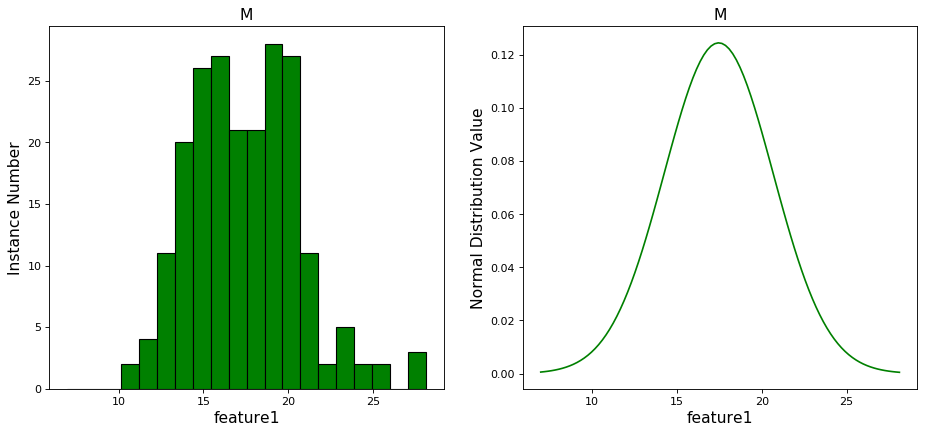

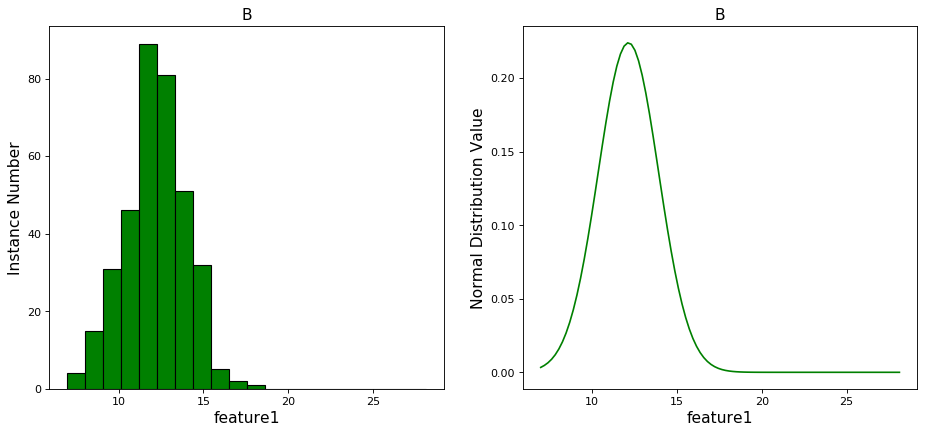

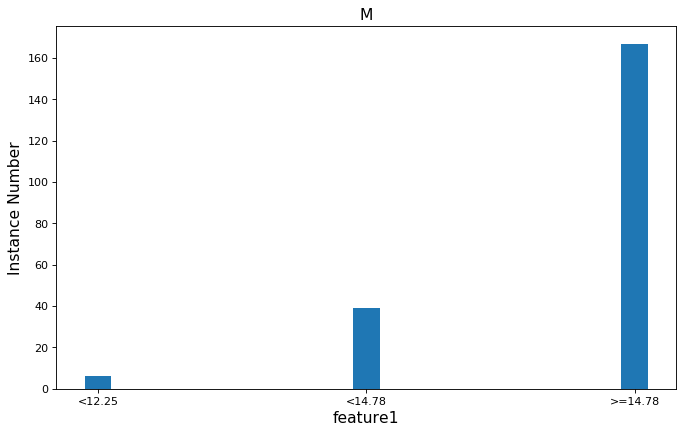

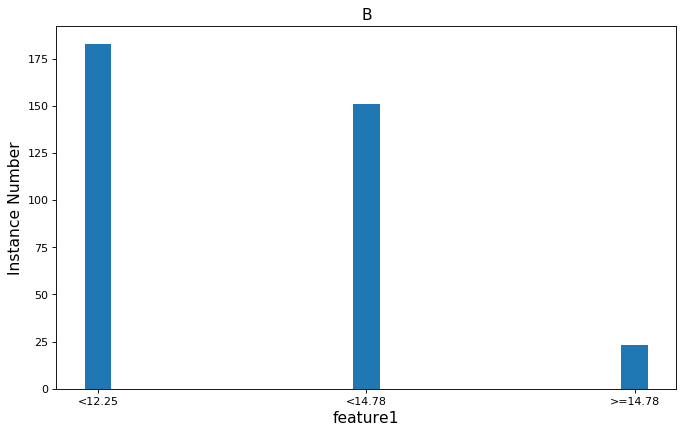

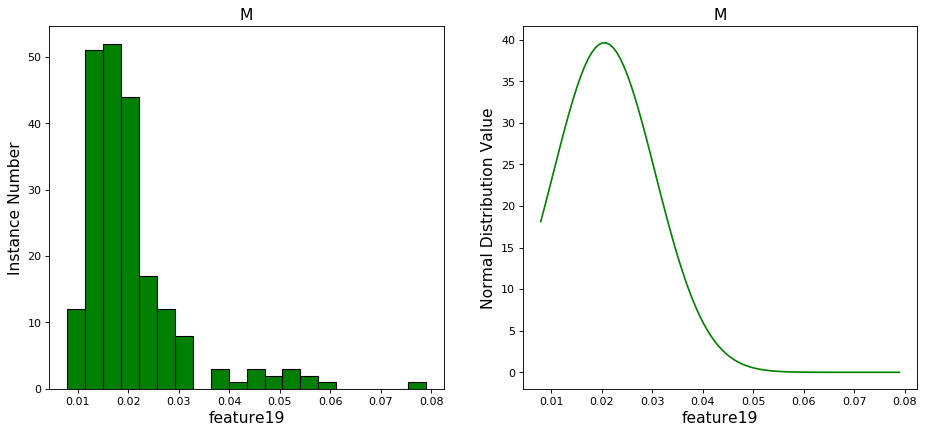

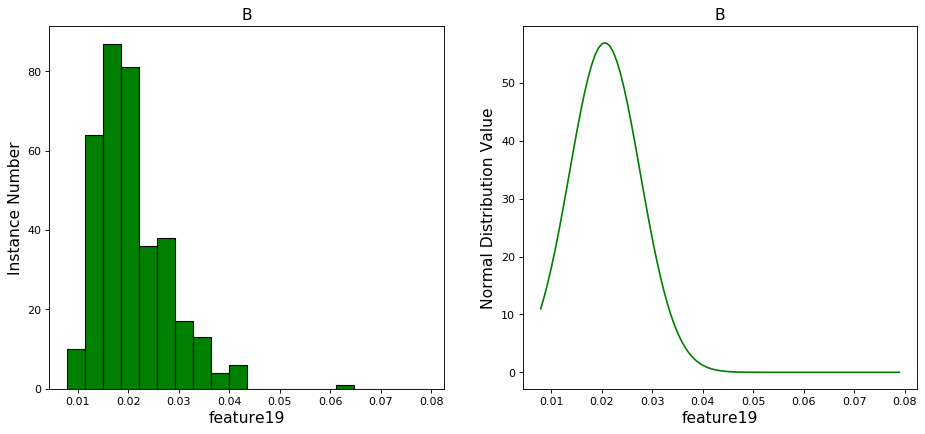

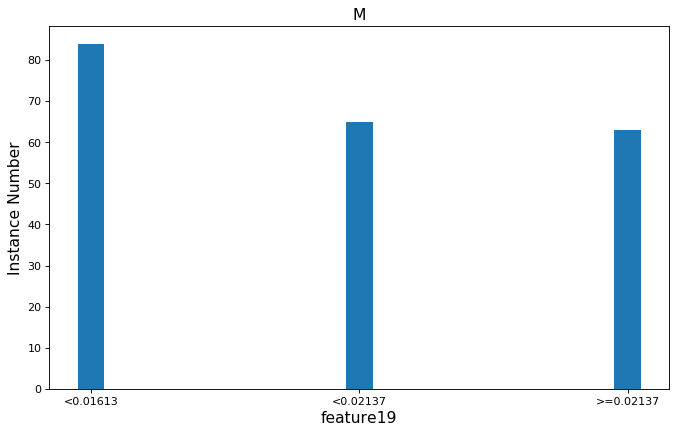

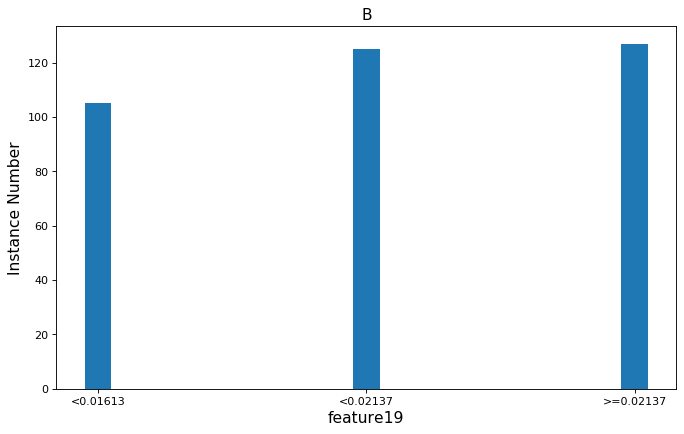

################# no discretisation result ##################
accuracy is: 0.940246
error rate is: 0.059754

----------------the macro averaging way------------------
Marco averaging precision is:  0.9393701316142895
Marco averaging recall is: 0.9322644152000423
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9402460456942003
Mirco averaging recall is: 0.9402460456942003
----------------the weight averaging way------------------
weight averaging precision is: 0.9401589983322217
weight averaging recall is: 0.9402460456942003


################# discretisation result ##################
accuracy is: 0.938489
error rate is: 0.061511

----------------the macro averaging way------------------
Marco averaging precision is:  0.9326102325094261
Marco averaging recall is: 0.9366114370276413
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9384885764499121
Mirco averaging recall is: 0.9384885764499121
-------------

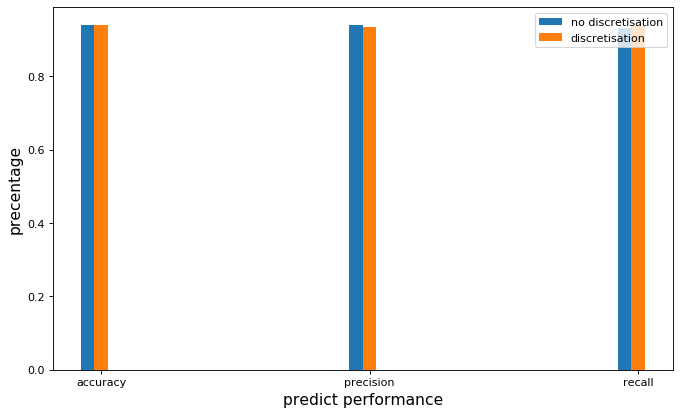

In [6]:
filename = "datasets/wdbc.data"
classes = ("M" , "B")
model1 = NB_Model(
    classes,
    ClassCounter("Diagnosis"),
    NumCounter('feature1'),
    NumCounter('feature2'),
    NumCounter('feature3'),
    NumCounter('feature4'),
    NumCounter('feature5'),
    NumCounter('feature6'),
    NumCounter('feature7'),
    NumCounter('feature8'),
    NumCounter('feature9'),
    NumCounter('feature10'),
    NumCounter('feature11'),
    NumCounter('feature12'),
    NumCounter('feature13'),
    NumCounter('feature14'),
    NumCounter('feature15'),
    NumCounter('feature16'),
    NumCounter('feature17'),
    NumCounter('feature18'),
    NumCounter('feature19'),
    NumCounter('feature20'),
    NumCounter('feature21'),
    NumCounter('feature22'),
    NumCounter('feature23'),
    NumCounter('feature24'),
    NumCounter('feature25'),
    NumCounter('feature26'),
    NumCounter('feature27'),
    NumCounter('feature28'),
    NumCounter('feature29'),
    NumCounter('feature30')
)
model1.set_filters(("none"))
model1.set_dump_firt_column(True)

model2 = NB_Model(
    classes,
    ClassCounter("Diagnosis"),
    Num2NomCounter('feature1',3),
    Num2NomCounter('feature2',3),
    Num2NomCounter('feature3',3),
    Num2NomCounter('feature4',3),
    Num2NomCounter('feature5',3),
    Num2NomCounter('feature6',3),
    Num2NomCounter('feature7',3),
    Num2NomCounter('feature8',3),
    Num2NomCounter('feature9',3),
    Num2NomCounter('feature10',3),
    Num2NomCounter('feature11',3),
    Num2NomCounter('feature12',3),
    Num2NomCounter('feature13',3),
    Num2NomCounter('feature14',3),
    Num2NomCounter('feature15',3),
    Num2NomCounter('feature16',3),
    Num2NomCounter('feature17',3),
    Num2NomCounter('feature18',3),
    Num2NomCounter('feature19',3),
    Num2NomCounter('feature20',3),
    Num2NomCounter('feature21',3),
    Num2NomCounter('feature22',3),
    Num2NomCounter('feature23',3),
    Num2NomCounter('feature24',3),
    Num2NomCounter('feature25',3),
    Num2NomCounter('feature26',3),
    Num2NomCounter('feature27',3),
    Num2NomCounter('feature28',3),
    Num2NomCounter('feature29',3),
    Num2NomCounter('feature30',3)
)
model2.set_filters(("none"))
model2.set_dump_firt_column(True)

with open(filename,"r") as file:
    lines = file.readlines()
    model1.preprocess(lines)
    model1.train()
    model2.preprocess(lines)
    model2.train()
    
    model1.draw_attr_distribution('feature1')
    model2.draw_attr_distribution('feature1')
    
    model1.draw_attr_distribution('feature19')
    model2.draw_attr_distribution('feature19')
    
    result1 = model1.predict(lines)
    result2 = model2.predict(lines)

    evaluation1 = Evaluation("no discretisation", classes, result1)
    evaluation1.evaluate()
    evaluation2 = Evaluation("discretisation", classes, result2)
    evaluation2.evaluate()
    
    compare_serveral_evaluation(evaluation1, evaluation2)  

################# no discretisation result ##################
accuracy is: 0.988764
error rate is: 0.011236

----------------the macro averaging way------------------
Marco averaging precision is:  0.9885024432308134
Marco averaging recall is: 0.9896554468051245
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9887640449438202
Mirco averaging recall is: 0.9887640449438202
----------------the weight averaging way------------------
weight averaging precision is: 0.9888786975464341
weight averaging recall is: 0.9887640449438202


################# discretisation - 5 levels result ##################
accuracy is: 0.988764
error rate is: 0.011236

----------------the macro averaging way------------------
Marco averaging precision is:  0.9876417233560092
Marco averaging recall is: 0.9906103286384976
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9887640449438202
Mirco averaging recall is: 0.9887640449438202
--

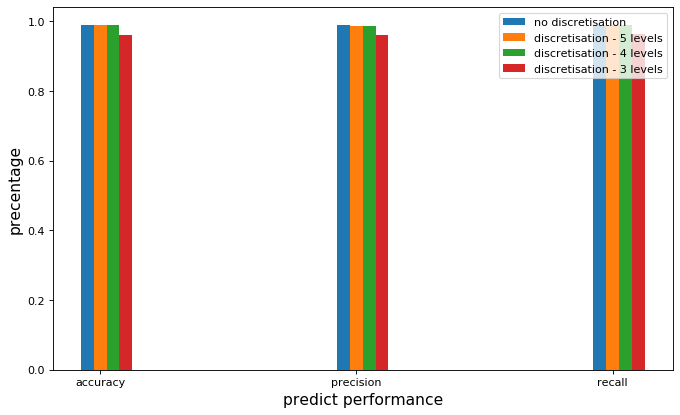

In [7]:
filename = "datasets/wine.data"
classes = ("1" , "2", "3")
model1 = NB_Model(
    classes,
    ClassCounter("Alcohol"),
    NumCounter("age"),
    NumCounter("Malic acid"),
    NumCounter("Ash"),
    NumCounter("Alcalinity of ash"),
    NumCounter("Magnesium"),
    NumCounter("Total phenols"),
    NumCounter("Flavanoids"),
    NumCounter("Nonflavanoid phenols"),
    NumCounter("Proanthocyanins"),
    NumCounter("Color intensity"),
    NumCounter("Hue"),
    NumCounter("OD280/OD315 of diluted wines"),
    NumCounter("Proline")
)

model2 = NB_Model(
    classes,
    ClassCounter("Alcohol"),
    Num2NomCounter("age",5),
    Num2NomCounter("Malic acid",5),
    Num2NomCounter("Ash",5),
    Num2NomCounter("Alcalinity of ash",5),
    Num2NomCounter("Magnesium",5),
    Num2NomCounter("Total phenols",5),
    Num2NomCounter("Flavanoids",5),
    Num2NomCounter("Nonflavanoid phenols",5),
    Num2NomCounter("Proanthocyanins",5),
    Num2NomCounter("Color intensity",5),
    Num2NomCounter("Hue",5),
    Num2NomCounter("OD280/OD315 of diluted wines",5),
    Num2NomCounter("Proline",5)
)

model3 = NB_Model(
    classes,
    ClassCounter("Alcohol"),
    Num2NomCounter("age",4),
    Num2NomCounter("Malic acid",4),
    Num2NomCounter("Ash",4),
    Num2NomCounter("Alcalinity of ash",4),
    Num2NomCounter("Magnesium",4),
    Num2NomCounter("Total phenols",4),
    Num2NomCounter("Flavanoids",4),
    Num2NomCounter("Nonflavanoid phenols",4),
    Num2NomCounter("Proanthocyanins",4),
    Num2NomCounter("Color intensity",4),
    Num2NomCounter("Hue",4),
    Num2NomCounter("OD280/OD315 of diluted wines",4),
    Num2NomCounter("Proline",4)
)

model4 = NB_Model(
    classes,
    ClassCounter("Alcohol"),
    Num2NomCounter("age",3),
    Num2NomCounter("Malic acid",3),
    Num2NomCounter("Ash",3),
    Num2NomCounter("Alcalinity of ash",3),
    Num2NomCounter("Magnesium",3),
    Num2NomCounter("Total phenols",3),
    Num2NomCounter("Flavanoids",3),
    Num2NomCounter("Nonflavanoid phenols",3),
    Num2NomCounter("Proanthocyanins",3),
    Num2NomCounter("Color intensity",3),
    Num2NomCounter("Hue",3),
    Num2NomCounter("OD280/OD315 of diluted wines",3),
    Num2NomCounter("Proline",3)
)

with open(filename,"r") as file:
    lines = file.readlines()
    model1.preprocess(lines)
    model1.train()
    model2.preprocess(lines)
    model2.train()
    model3.preprocess(lines)
    model3.train()
    model4.preprocess(lines)
    model4.train()
    
    result1 = model1.predict(lines)
    result2 = model2.predict(lines)
    result3 = model3.predict(lines)
    result4 = model4.predict(lines)

    evaluation1 = Evaluation("no discretisation", classes, result1)
    evaluation1.evaluate()
    evaluation2 = Evaluation("discretisation - 5 levels", classes, result2)
    evaluation2.evaluate()
    evaluation3 = Evaluation("discretisation - 4 levels", classes, result3)
    evaluation3.evaluate()
    evaluation4 = Evaluation("discretisation - 3 levels", classes, result4)
    evaluation4.evaluate()
    
    compare_serveral_evaluation(evaluation1, evaluation2, evaluation3, evaluation4) 

### Q2
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

In [8]:
#compare with the result of spliting data for the accuracy
#Nursery Dataset
filename = "datasets/nursery.data"
classes = ('not_recom','recommend','very_recom','priority','spec_prior')
model = NB_Model(
    classes,
    NomCounter('parents'),
    NomCounter('has_nurs'),
    NomCounter('form'),
    NomCounter('children'),
    NomCounter('housing'),
    NomCounter('finance'),
    NomCounter('social'),
    NomCounter('health'),
    ClassCounter('recommendation')
)
model.set_filters(("none"))

model2 = NB_Model(
    classes,
    NomCounter('parents'),
    NomCounter('has_nurs'),
    NomCounter('form'),
    NomCounter('children'),
    NomCounter('housing'),
    NomCounter('finance'),
    NomCounter('social'),
    NomCounter('health'),
    ClassCounter('recommendation')
)

#Split Training set and Test set (8:2)
print("test for Nursery Dataset (split data into 80% for training and 20% for test)\n")
with open(filename,"r") as file:
    lines = file.readlines()
    random.seed(0)
    random.shuffle(lines)
    percentage = 0.8
    train_lines = lines[0:int(len(lines)*percentage)]
    test_lines = lines[int(len(lines)*percentage):]
    model.preprocess(train_lines)
    model.train()
    result = model.predict(test_lines)
    evaluation1 = Evaluation("nursery dataset - splited", classes, result1)
    evaluation1.evaluate()
    
#Take Training set as Test set 
print("test for Nursery Dataset (no test data)\n")
with open(filename,"r") as file:
    lines = file.readlines()
    model2.preprocess(lines)
    model2.train()
    result2 = model2.predict(lines)
    evaluation2 = Evaluation("nursery dataset", classes, result2)
    evaluation2.evaluate()

test for Nursery Dataset (split data into 80% for training and 20% for test)

################# nursery dataset - splited result ##################
accuracy is: 0.988764
error rate is: 0.011236

----------------the macro averaging way------------------
Marco averaging precision is:  0.593101465938488
Marco averaging recall is: 0.5937932680830748
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9887640449438202
Mirco averaging recall is: 0.9887640449438202
----------------the weight averaging way------------------
weight averaging precision is: 0.9888786975464341
weight averaging recall is: 0.9887640449438202


test for Nursery Dataset (no test data)

################# nursery dataset result ##################
accuracy is: 0.903009
error rate is: 0.096991

----------------the macro averaging way------------------
Marco averaging precision is:  0.7248820267369591
Marco averaging recall is: 0.5664257996860103
----------------the micro averaging way

################# wine NB_model result ##################
accuracy is: 0.988764
error rate is: 0.011236

----------------the macro averaging way------------------
Marco averaging precision is:  0.9885024432308134
Marco averaging recall is: 0.9896554468051245
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9887640449438202
Mirco averaging recall is: 0.9887640449438202
----------------the weight averaging way------------------
weight averaging precision is: 0.9888786975464341
weight averaging recall is: 0.9887640449438202




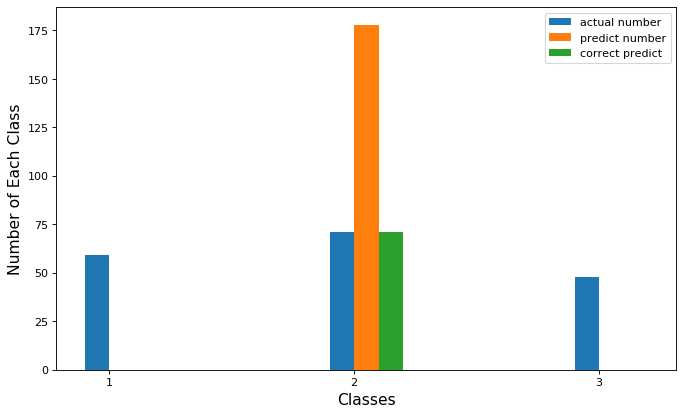

################# wine baseline result ##################
accuracy is: 0.398876
error rate is: 0.601124

----------------the macro averaging way------------------
Marco averaging precision is:  0.13295880149812733
Marco averaging recall is: 0.3333333333333333
----------------the micro averaging way------------------
Mirco averaging precision is: 0.398876404494382
Mirco averaging recall is: 0.398876404494382
----------------the weight averaging way------------------
weight averaging precision is: 0.15910238606236585
weight averaging recall is: 0.398876404494382




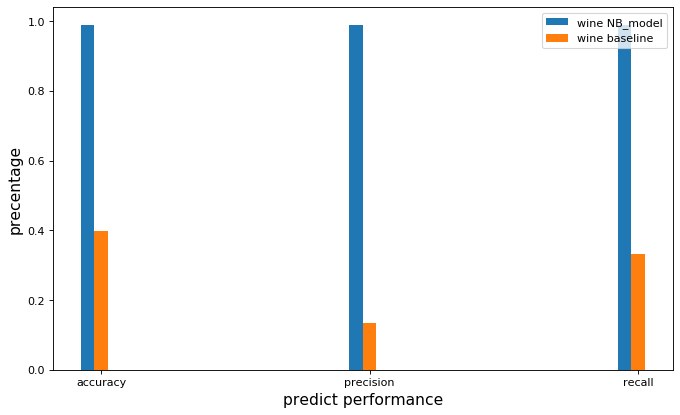

In [9]:
#wine.data
filename = "datasets/wine.data"
classes = ("1" , "2", "3")
model = NB_Model(
    classes,
    ClassCounter("Alcohol"),
    NumCounter("age"),
    NumCounter("Malic acid"),
    NumCounter("Ash"),
    NumCounter("Alcalinity of ash"),
    NumCounter("Magnesium"),
    NumCounter("Total phenols"),
    NumCounter("Flavanoids"),
    NumCounter("Nonflavanoid phenols"),
    NumCounter("Proanthocyanins"),
    NumCounter("Color intensity"),
    NumCounter("Hue"),
    NumCounter("OD280/OD315 of diluted wines"),
    NumCounter("Proline")
)

with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()
    result = model.predict(lines)
    result2 = model.predict_baseline(lines)
    wine_evaluation1 = Evaluation("wine NB_model", classes, result)
    wine_evaluation1.evaluate()
    wine_evaluation2 = Evaluation("wine baseline", classes, result2)
    wine_evaluation2.draw_bar_chart()
    wine_evaluation2.evaluate()
    
    compare_serveral_evaluation(wine_evaluation1, wine_evaluation2)   

################# car NB_model result ##################
accuracy is: 0.871528
error rate is: 0.128472

----------------the macro averaging way------------------
Marco averaging precision is:  0.8040352387146505
Marco averaging recall is: 0.6378405556688042
----------------the micro averaging way------------------
Mirco averaging precision is: 0.8715277777777778
Mirco averaging recall is: 0.8715277777777778
----------------the weight averaging way------------------
weight averaging precision is: 0.8688062641518524
weight averaging recall is: 0.8715277777777779


################# car baseline result ##################
accuracy is: 0.700231
error rate is: 0.299769

----------------the macro averaging way------------------
Marco averaging precision is:  0.17505787037037038
Marco averaging recall is: 0.25
----------------the micro averaging way------------------
Mirco averaging precision is: 0.7002314814814815
Mirco averaging recall is: 0.7002314814814815
----------------the weight averag

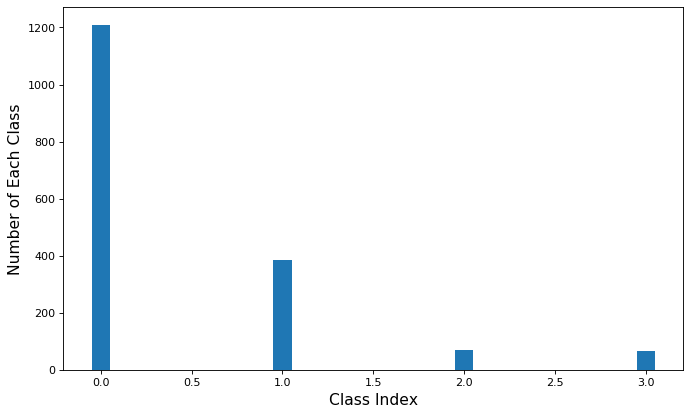

In [10]:
#Car Dataset

filename = "datasets/car.data"
classes = ("unacc" , "acc", "good", "vgood")
model = NB_Model(
    classes,
    NomCounter("buying"),
    NomCounter("maint"),
    NomCounter("doors"),
    NomCounter("persons"),
    NomCounter("lug_boot"),
    NomCounter("safety"),
    ClassCounter("Car Evaluation")
)
with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()
    car_result = model.predict(lines)
    car_result2 = model.predict_baseline(lines)
    car_evaluation1 = Evaluation("car NB_model", classes, car_result)
    car_evaluation1.evaluate()
    car_evaluation2 = Evaluation("car baseline", classes, car_result2)
    #car_evaluation2.draw_bar_chart()
    car_evaluation2.evaluate()   

print("\nClass Distribution")
print("number: ")
distribution = model.get_classes_count()
print(distribution)
print("percentage: ")
distribution_percentage = [round(element/sum(distribution), 3) for element in distribution]
print(distribution_percentage)

#use the graph to show the distribution
plt.figure(figsize=(10,6), dpi=80)
names = ["class1", "class2", "class3", "class4"]
x = range(len(names))
        
plt.bar(x, distribution, width=0.1)
plt.xlabel('Class Index', fontsize=14)
plt.ylabel('Number of Each Class', fontsize=14)
plt.show()

################# lymphography NB_model result ##################
accuracy is: 0.885135
error rate is: 0.114865

----------------the macro averaging way------------------
Marco averaging precision is:  0.8637078330474557
Marco averaging recall is: 0.9353875733657154
----------------the micro averaging way------------------
Mirco averaging precision is: 0.8851351351351351
Mirco averaging recall is: 0.8851351351351351
----------------the weight averaging way------------------
weight averaging precision is: 0.8897574675876563
weight averaging recall is: 0.8851351351351351


################# lymphography baseline result ##################
accuracy is: 0.547297
error rate is: 0.452703

----------------the macro averaging way------------------
Marco averaging precision is:  0.13682432432432431
Marco averaging recall is: 0.25
----------------the micro averaging way------------------
Mirco averaging precision is: 0.5472972972972973
Mirco averaging recall is: 0.5472972972972973
---------------

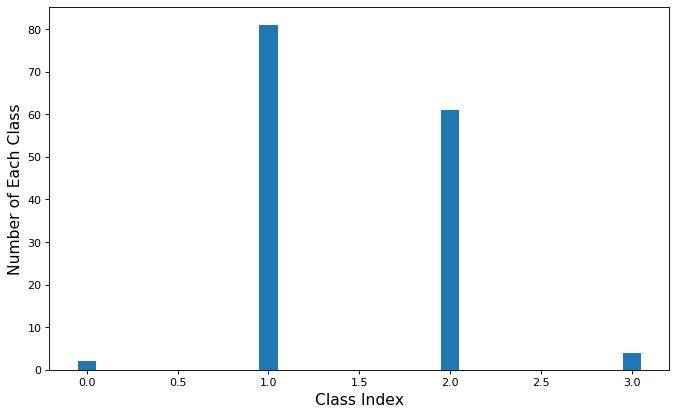

In [11]:
#lymphography Dataset

filename = "datasets/lymphography.data"
classes = ('1', '2', '3', '4') 
model = NB_Model(
    classes,
    ClassCounter('class'),
    NomCounter('lymphatics'),
    NomCounter('block of affere'),
    NomCounter('bl. of lymph. c'),
    NomCounter('bl. of lymph. s'),
    NomCounter('by pass'),
    NomCounter('extravasates'),
    NomCounter('regeneration of'),
    NomCounter('early uptake'),
    NomCounter('lym.nodes dimin'),
    NomCounter('lym.nodes enlar'),
    NomCounter('changes in lym'),
    NomCounter('defect in node'),
    NomCounter('changes in node'),
    NomCounter('changes in stru'),
    NomCounter('special forms'),
    NomCounter('dislocation of'),
    NomCounter('exclusion of no'),
    NomCounter('exclusion of no')
)

with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()
    lymphography_result = model.predict(lines)
    lymphography_result2 = model.predict_baseline(lines)
    lymphography_evaluation1 = Evaluation("lymphography NB_model", classes, lymphography_result)
    lymphography_evaluation1.evaluate()
    lymphography_evaluation2 = Evaluation("lymphography baseline", classes, lymphography_result2)
    lymphography_evaluation2.evaluate()
    

print("\nClass Distribution")
print("number: ")
distribution = model.get_classes_count()
print(distribution)
print("percentage: ")
distribution_percentage = [round(element/sum(distribution), 3) for element in distribution]
print(distribution_percentage)

#use the graph to show
plt.figure(figsize=(10,6), dpi=80)
names = ["class1", "class2", "class3", "class4"]
x = range(len(names))
        
plt.bar(x, distribution, width=0.1)
plt.xlabel('Class Index', fontsize=14)
plt.ylabel('Number of Each Class', fontsize=14)
plt.show()

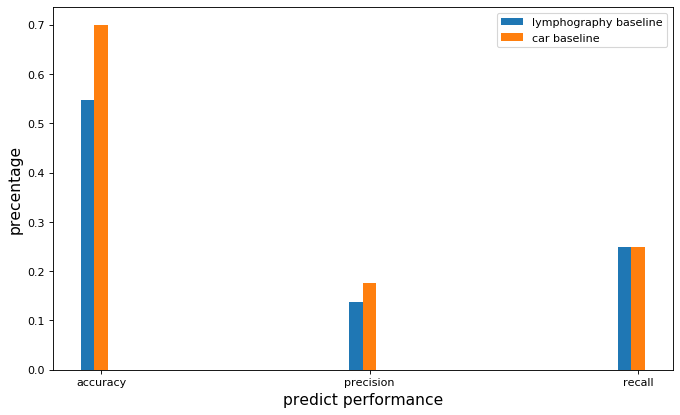

In [12]:
#compare baseline evaluation
compare_serveral_evaluation(lymphography_evaluation2, car_evaluation2) 

################# wisconsin NB_model result ##################
accuracy is: 0.974249
error rate is: 0.025751

----------------the macro averaging way------------------
Marco averaging precision is:  0.9669925025257449
Marco averaging recall is: 0.9774003877584301
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9742489270386266
Mirco averaging recall is: 0.9742489270386266
----------------the weight averaging way------------------
weight averaging precision is: 0.9751512803459279
weight averaging recall is: 0.9742489270386266


################# wisconsin baseline result ##################
accuracy is: 0.655222
error rate is: 0.344778

----------------the macro averaging way------------------
Marco averaging precision is:  0.32761087267525035
Marco averaging recall is: 0.5
----------------the micro averaging way------------------
Mirco averaging precision is: 0.6552217453505007
Mirco averaging recall is: 0.6552217453505007
----------------the we

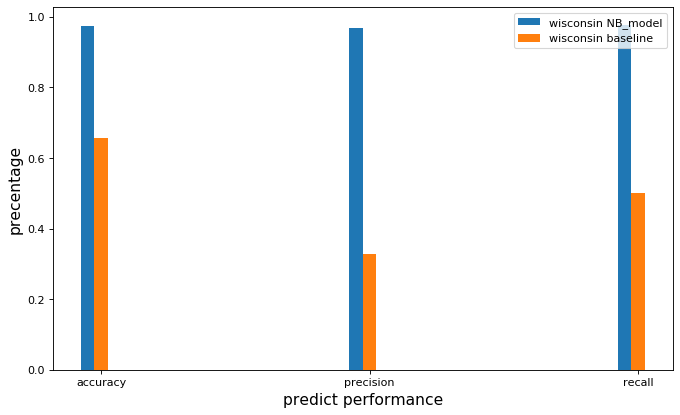


Class Distribution
number: 
[458, 241]
percentage: 
[0.655, 0.345]


In [13]:
#breast-cancer-wisconsin Dataset
filename = "datasets/breast-cancer-wisconsin.data"
classes = ("2" , "4")

model = NB_Model(
    classes,
    NomCounter('Clump Thickness'),
    NomCounter('Uniformity of Cell Size'),
    NomCounter('Uniformity of Cell Shape'),
    NomCounter('Marginal Adhesion'),
    NomCounter('Single Epithelial Cell Size'),
    NomCounter('Bare Nuclei'),
    NomCounter('Bland Chromatin'),
    NomCounter('Normal Nucleoli'),
    NomCounter('Mitoses'),
    ClassCounter('benign or not')
)
model.set_filters("?")
model.set_dump_firt_column(True)

with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()
    result = model.predict(lines)
    result2 = model.predict_baseline(lines)
    breast_evaluation1 = Evaluation("wisconsin NB_model", classes, result)
    breast_evaluation1.evaluate()
    breast_evaluation2 = Evaluation("wisconsin baseline", classes, result2)
    breast_evaluation2.evaluate()
    
    compare_serveral_evaluation(breast_evaluation1, breast_evaluation2)  

print("\nClass Distribution")
print("number: ")
distribution = model.get_classes_count()
print(distribution)
print("percentage: ")
distribution_percentage = [round(element/sum(distribution), 3) for element in distribution]
print(distribution_percentage)


################# wdbc NB_model result ##################
accuracy is: 0.940246
error rate is: 0.059754

----------------the macro averaging way------------------
Marco averaging precision is:  0.9393701316142895
Marco averaging recall is: 0.9322644152000423
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9402460456942003
Mirco averaging recall is: 0.9402460456942003
----------------the weight averaging way------------------
weight averaging precision is: 0.9401589983322217
weight averaging recall is: 0.9402460456942003


################# wdbc baseline result ##################
accuracy is: 0.627417
error rate is: 0.372583

----------------the macro averaging way------------------
Marco averaging precision is:  0.31370826010544817
Marco averaging recall is: 0.5
----------------the micro averaging way------------------
Mirco averaging precision is: 0.6274165202108963
Mirco averaging recall is: 0.6274165202108963
----------------the weight avera

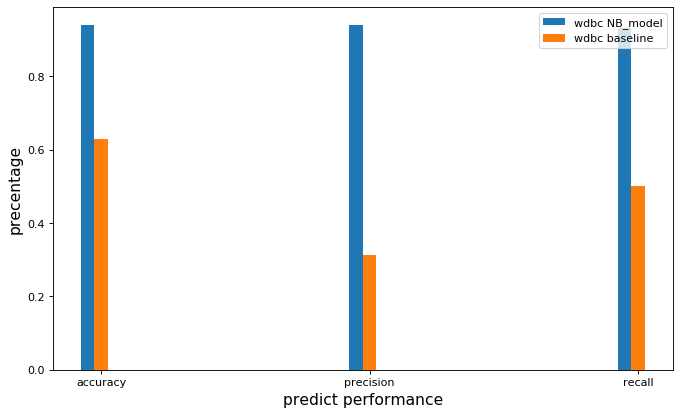

In [14]:
#wdbc dataset
filename = "datasets/wdbc.data"
classes = ("M" , "B")
model1 = NB_Model(
    classes,
    ClassCounter("Diagnosis"),
    NumCounter('feature3'),
    NumCounter('feature4'),
    NumCounter('feature5'),
    NumCounter('feature6'),
    NumCounter('feature7'),
    NumCounter('feature8'),
    NumCounter('feature9'),
    NumCounter('feature10'),
    NumCounter('feature11'),
    NumCounter('feature12'),
    NumCounter('feature13'),
    NumCounter('feature14'),
    NumCounter('feature15'),
    NumCounter('feature16'),
    NumCounter('feature17'),
    NumCounter('feature18'),
    NumCounter('feature19'),
    NumCounter('feature20'),
    NumCounter('feature21'),
    NumCounter('feature22'),
    NumCounter('feature23'),
    NumCounter('feature24'),
    NumCounter('feature25'),
    NumCounter('feature26'),
    NumCounter('feature27'),
    NumCounter('feature28'),
    NumCounter('feature29'),
    NumCounter('feature30'),
    NumCounter('feature31'),
    NumCounter('feature32')
)
model1.set_dump_firt_column(True)


with open(filename,"r") as file:
    lines = file.readlines()
    model1.preprocess(lines)
    model1.train()

    
    result1 = model1.predict(lines)
    result2 = model1.predict_baseline(lines)
    
    wdbc_evaluation1 = Evaluation("wdbc NB_model", classes, result1)
    wdbc_evaluation1.evaluate()
    wdbc_evaluation2 = Evaluation("wdbc baseline", classes, result2)
    wdbc_evaluation2.evaluate()
    
    compare_serveral_evaluation(wdbc_evaluation1, wdbc_evaluation2)

################# somerville NB_model result ##################
accuracy is: 0.678322
error rate is: 0.321678

----------------the macro averaging way------------------
Marco averaging precision is:  0.6763241736360015
Marco averaging recall is: 0.6742424242424243
----------------the micro averaging way------------------
Mirco averaging precision is: 0.6783216783216783
Mirco averaging recall is: 0.6783216783216783
----------------the weight averaging way------------------
weight averaging precision is: 0.6774806237171829
weight averaging recall is: 0.6783216783216783


################# somerville baseline result ##################
accuracy is: 0.538462
error rate is: 0.461538

----------------the macro averaging way------------------
Marco averaging precision is:  0.2692307692307692
Marco averaging recall is: 0.5
----------------the micro averaging way------------------
Mirco averaging precision is: 0.5384615384615384
Mirco averaging recall is: 0.5384615384615384
----------------the w

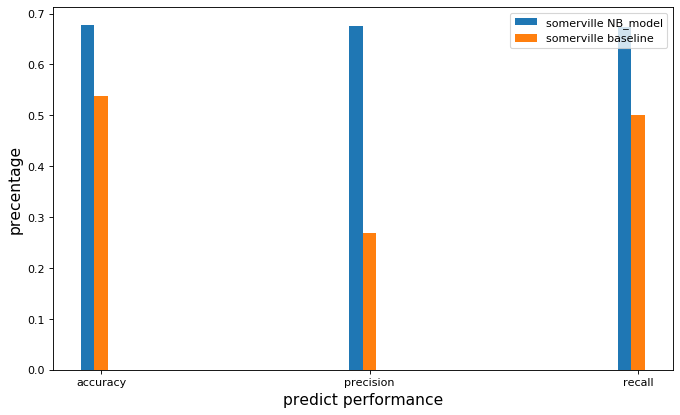

In [15]:
#somerville Dataset 
filename = "datasets/somerville.data"
classes = ('0', '1')
model = NB_Model(
    classes,
    ClassCounter('Decision'),
    Ord2NomCounter('X1',int),
    Ord2NomCounter('X2',int),
    Ord2NomCounter('X3',int),
    Ord2NomCounter('X4',int),
    Ord2NomCounter('X5',int),
    Ord2NomCounter('X6',int)
)

with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()

    
    result1 = model.predict(lines)
    result2 = model.predict_baseline(lines)
    
    somerville_evaluation1 = Evaluation("somerville NB_model", classes, result1)
    somerville_evaluation1.evaluate()
    somerville_evaluation2 = Evaluation("somerville baseline", classes, result2)
    somerville_evaluation2.evaluate()
    
    compare_serveral_evaluation(somerville_evaluation1, somerville_evaluation2)

################# adult NB_model result ##################
accuracy is: 0.832499
error rate is: 0.167501

----------------the macro averaging way------------------
Marco averaging precision is:  0.7842994650934391
Marco averaging recall is: 0.7237938679309529
----------------the micro averaging way------------------
Mirco averaging precision is: 0.8324990018734069
Mirco averaging recall is: 0.8324990018734069
----------------the weight averaging way------------------
weight averaging precision is: 0.8226550344352463
weight averaging recall is: 0.8324990018734069


################# adult baseline result ##################
accuracy is: 0.759190
error rate is: 0.240810

----------------the macro averaging way------------------
Marco averaging precision is:  0.3795952212769878
Marco averaging recall is: 0.5
----------------the micro averaging way------------------
Mirco averaging precision is: 0.7591904425539756
Mirco averaging recall is: 0.7591904425539756
----------------the weight aver

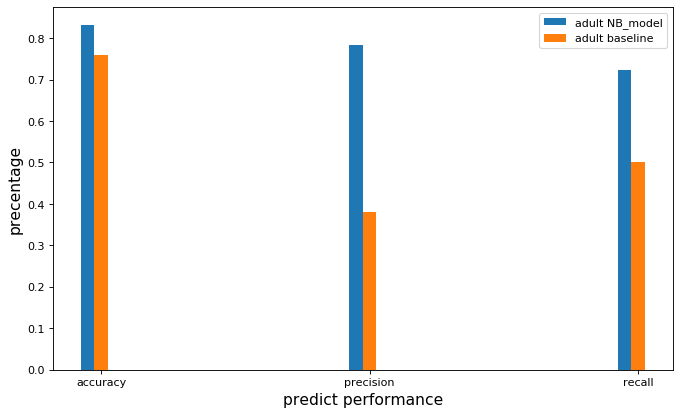

In [16]:
#Adult Dataset 
filename = "datasets/adult.data"
classes = ("<=50K" , ">50K")
model = NB_Model(
    classes,
    NumCounter("age"),
    NomCounter("workclass"),
    NumCounter("fnlwgt"),
    Ord2NomCounter("education"),
    Ord2NomCounter("education-num"),
    NomCounter("marital-status"),
    NomCounter("occupation"),
    NomCounter("relationship"),
    NomCounter("race"),
    NomCounter("sex"),
    NumCounter("capital-gain"),
    NumCounter("capital-loss"),
    NumCounter("hours-per-week"),
    NomCounter("native-country"),
    ClassCounter("salary")
)
model.set_filters("?")

with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()

    
    result1 = model.predict(lines)
    result2 = model.predict_baseline(lines)
    
    adult_evaluation1 = Evaluation("adult NB_model", classes, result1)
    adult_evaluation1.evaluate()
    adult_evaluation2 = Evaluation("adult baseline", classes, result2)
    adult_evaluation2.evaluate()
    
    compare_serveral_evaluation(adult_evaluation1, adult_evaluation2)

################# bank NB_model result ##################
accuracy is: 0.876999
error rate is: 0.123001

----------------the macro averaging way------------------
Marco averaging precision is:  0.7042168478479625
Marco averaging recall is: 0.7123653674296188
----------------the micro averaging way------------------
Mirco averaging precision is: 0.8769989604299838
Mirco averaging recall is: 0.8769989604299838
----------------the weight averaging way------------------
weight averaging precision is: 0.8794786263985628
weight averaging recall is: 0.8769989604299839


################# bank baseline result ##################
accuracy is: 0.883015
error rate is: 0.116985

----------------the macro averaging way------------------
Marco averaging precision is:  0.44150759770852227
Marco averaging recall is: 0.5
----------------the micro averaging way------------------
Mirco averaging precision is: 0.8830151954170445
Mirco averaging recall is: 0.8830151954170445
----------------the weight avera

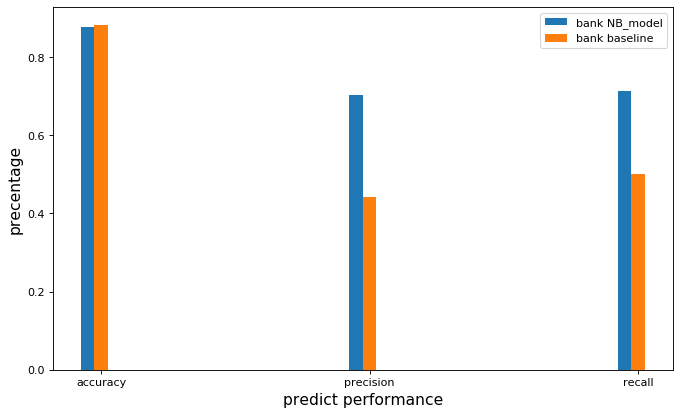

In [17]:
#Bank Dataset

filename = "datasets/bank.data"
classes = ("yes" , "no")
model = NB_Model(
    classes,
    NumCounter('age'),
    NomCounter('job'),
    NomCounter('marital'),
    Ord2NomCounter('education'),
    NomCounter('default'),
    NumCounter('balance'),
    NomCounter('housing'),
    NomCounter('loan'),
    NomCounter('contact'), 
    NumCounter('day'),
    NumCounter('duration'),
    NumCounter('campaign'),
    NumCounter('pdays'),
    NomCounter('poutcome'),
    ClassCounter('y')
)

with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()

    result1 = model.predict(lines)
    result2 = model.predict_baseline(lines)
    
    bank_evaluation1 = Evaluation("bank NB_model", classes, result1)
    bank_evaluation1.evaluate()
    bank_evaluation2 = Evaluation("bank baseline", classes, result2)
    bank_evaluation2.evaluate()
    
    compare_serveral_evaluation(bank_evaluation1, bank_evaluation2)

################# mushroom NB_model result ##################
accuracy is: 0.958887
error rate is: 0.041113

----------------the macro averaging way------------------
Marco averaging precision is:  0.9618912182849437
Marco averaging recall is: 0.9576379637792891
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9588872476612507
Mirco averaging recall is: 0.9588872476612507
----------------the weight averaging way------------------
weight averaging precision is: 0.960836940133359
weight averaging recall is: 0.9588872476612507


################# mushroom baseline result ##################
accuracy is: 0.517971
error rate is: 0.482029

----------------the macro averaging way------------------
Marco averaging precision is:  0.258985721319547
Marco averaging recall is: 0.5
----------------the micro averaging way------------------
Mirco averaging precision is: 0.517971442639094
Mirco averaging recall is: 0.517971442639094
----------------the weight av

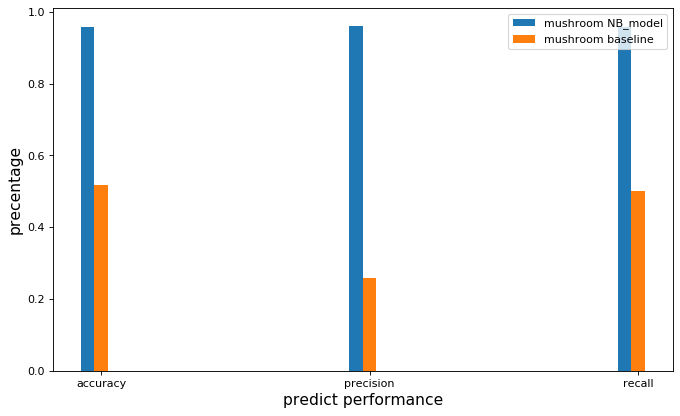

In [18]:
#mushroom dataset
filename = "datasets/mushroom.data"
classes = ('e', 'p')
model = NB_Model(
    classes,
    ClassCounter('class'),
    NomCounter('cap-shape'),
    NomCounter('cap-surface'),
    NomCounter('cap-color'),
    NomCounter('bruises?'),
    NomCounter('odor'),
    NomCounter('gill-attachment'),
    NomCounter('gill-spacing'),
    NomCounter('gill-size'),
    NomCounter('gill-color'),
    NomCounter('stalk-shape'),
    NomCounter('stalk-root'),
    NomCounter('stalk-surface-above-ring'),
    NomCounter('stalk-surface-below-ring'),
    NomCounter('stalk-color-above-ring'),
    NomCounter('veil-type'),
    NomCounter('stalk-color-below-ring'),
    NomCounter('veil-color'),
    NomCounter('ring-number'),
    NomCounter('ring-type'),
    NomCounter('spore-print-color'),
    NomCounter('population'),
    NomCounter('habitat')
)
model.set_filters("?") 

with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()

    
    result1 = model.predict(lines)
    result2 = model.predict_baseline(lines)
    
    mushroom_evaluation1 = Evaluation("mushroom NB_model", classes, result1)
    mushroom_evaluation1.evaluate()
    mushroom_evaluation2 = Evaluation("mushroom baseline", classes, result2)
    mushroom_evaluation2.evaluate()
    
    compare_serveral_evaluation(mushroom_evaluation1, mushroom_evaluation2)

################# nursery NB_model result ##################
accuracy is: 0.903009
error rate is: 0.096991

----------------the macro averaging way------------------
Marco averaging precision is:  0.7248820267369591
Marco averaging recall is: 0.5664257996860103
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9030092592592592
Mirco averaging recall is: 0.9030092592592592
----------------the weight averaging way------------------
weight averaging precision is: 0.905644265528916
weight averaging recall is: 0.9030092592592592


################# nursery baseline result ##################
accuracy is: 0.333333
error rate is: 0.666667

----------------the macro averaging way------------------
Marco averaging precision is:  0.06666666666666667
Marco averaging recall is: 0.2
----------------the micro averaging way------------------
Mirco averaging precision is: 0.3333333333333333
Mirco averaging recall is: 0.3333333333333333
----------------the weight 

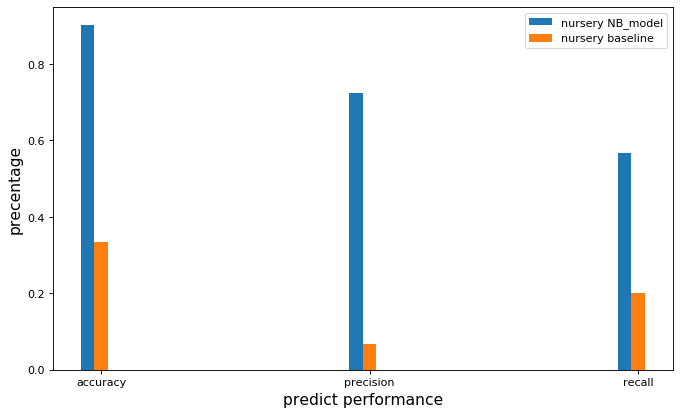

In [19]:
#Nursery Dataset
filename = "datasets/nursery.data"
classes = ('not_recom','recommend','very_recom','priority','spec_prior')
model = NB_Model(
    classes,
    NomCounter('parents'),
    NomCounter('has_nurs'),
    NomCounter('form'),
    NomCounter('children'),
    NomCounter('housing'),
    NomCounter('finance'),
    NomCounter('social'),
    NomCounter('health'),
    ClassCounter('recommendation')
)

with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()

    
    result1 = model.predict(lines)
    result2 = model.predict_baseline(lines)
    
    nursery_evaluation1 = Evaluation("nursery NB_model", classes, result1)
    nursery_evaluation1.evaluate()
    nursery_evaluation2 = Evaluation("nursery baseline", classes, result2)
    nursery_evaluation2.evaluate()
    
    compare_serveral_evaluation(nursery_evaluation1, nursery_evaluation2)

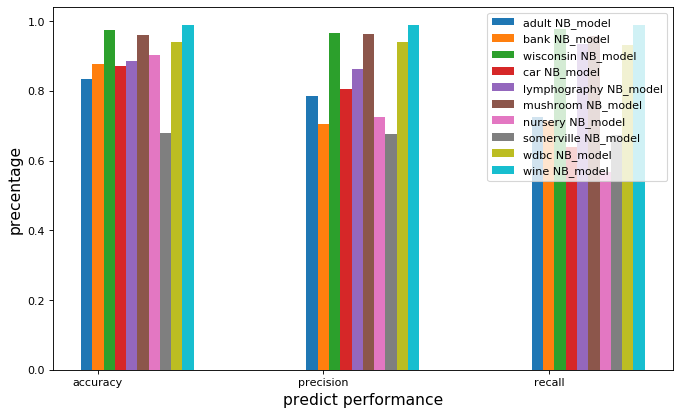

In [20]:
compare_serveral_evaluation(adult_evaluation1, bank_evaluation1, breast_evaluation1, car_evaluation1, lymphography_evaluation1, mushroom_evaluation1, nursery_evaluation1, somerville_evaluation1, wdbc_evaluation1, wine_evaluation1)


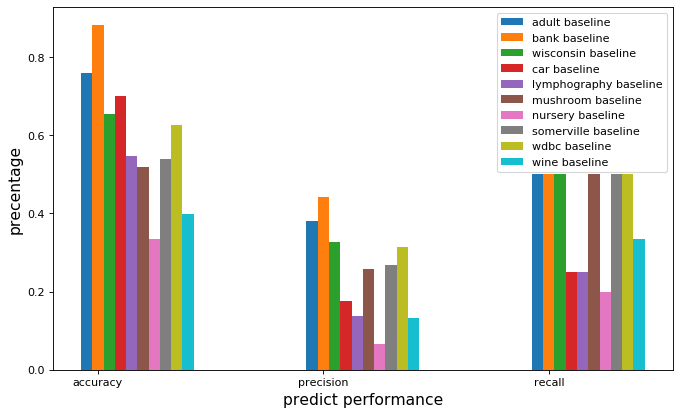

In [21]:
compare_serveral_evaluation(adult_evaluation2, bank_evaluation2, breast_evaluation2, car_evaluation2, lymphography_evaluation2, mushroom_evaluation2, nursery_evaluation2, somerville_evaluation2, wdbc_evaluation2, wine_evaluation2)


### Q3
Since it’s difficult to model the probabilities of ordinal data, ordinal attributes are often treated as either nominal variables or numeric variables. Compare these strategies on the ordinal datasets provided. Deterimine which approach gives higher classification accuracy and discuss why.

In [22]:
#######Compare different value for the converting the ordinal data to the numeric data####
#######In order to find out the most accuracy option###########

In [23]:
filename = "datasets/car.data"
classes = ("unacc" , "acc", "good", "vgood")
car_2num = NB_Model(
    classes,
    Ord2NumCounter("buying", lambda x: {"vhigh":3, "high":2, "med":1, "low":0}[x]),
    Ord2NumCounter("maint", lambda x: {"vhigh":3, "high":2, "med":1, "low":0}[x]),
    Ord2NumCounter("doors", lambda x: {"5more":3, "4":2, "3":1, "2":0}[x]),
    Ord2NumCounter("persons", lambda x: {"more":2, "4":1, "2":0}[x]),
    Ord2NumCounter("lug_boot", lambda x: {"big":2, "med":1, "small":0}[x]),
    Ord2NumCounter("safety", lambda x: {"high":2, "med":1, "low":0}[x]),
    ClassCounter("Car Evaluation")
)

with open(filename,"r") as file:
    lines = file.readlines()
    car_2num.preprocess(lines)
    car_2num.train()
    #car_2num.draw_attr_distribution()
    result2 = car_2num.predict(lines)
    evaluation_single = Evaluation("Cuse 1, 2, 3, 4 to map attribute", classes, result2)
    print("use 1, 2, 3, 4 to map attribute")
    evaluation_single.evaluate()
    #evaluation2.draw_bar_chart()

use 1, 2, 3, 4 to map attribute
################# Cuse 1, 2, 3, 4 to map attribute result ##################
accuracy is: 0.808449
error rate is: 0.191551

----------------the macro averaging way------------------
Marco averaging precision is:  0.4911436895877529
Marco averaging recall is: 0.46454782196969696
----------------the micro averaging way------------------
Mirco averaging precision is: 0.8084490740740741
Mirco averaging recall is: 0.8084490740740741
----------------the weight averaging way------------------
weight averaging precision is: 0.7668494144356257
weight averaging recall is: 0.8084490740740741




In [24]:
car_2num = NB_Model(
    classes,
    Ord2NumCounter("buying", lambda x: {"vhigh":0.3, "high":0.2, "med":0.1, "low":0}[x]),
    Ord2NumCounter("maint", lambda x: {"vhigh":0.3, "high":0.2, "med":0.1, "low":0}[x]),
    Ord2NumCounter("doors", lambda x: {"5more":0.3, "4":0.2, "3":0.1, "2":0}[x]),
    Ord2NumCounter("persons", lambda x: {"more":0.2, "4":0.1, "2":0}[x]),
    Ord2NumCounter("lug_boot", lambda x: {"big":0.2, "med":0.1, "small":0}[x]),
    Ord2NumCounter("safety", lambda x: {"high":0.2, "med":0.1, "low":0}[x]),
    ClassCounter("Car Evaluation")
)

with open(filename,"r") as file:
    lines = file.readlines()
    car_2num.preprocess(lines)
    car_2num.train()
    #car_2num.draw_attr_distribution()
    result2 = car_2num.predict(lines)
    evaluation_float= Evaluation("use 0.1, 0.2, 0.3, 0.4 to map attribute", classes, result2)
    print("use 0.1, 0.2, 0.3, 0.4 to map attribute")
    evaluation_float.evaluate()
    #evaluation2.draw_bar_chart()
    #compare_serveral_evaluation(evaluation1, evaluation2)

use 0.1, 0.2, 0.3, 0.4 to map attribute
################# use 0.1, 0.2, 0.3, 0.4 to map attribute result ##################
accuracy is: 0.612269
error rate is: 0.387731

----------------the macro averaging way------------------
Marco averaging precision is:  0.5757509681370077
Marco averaging recall is: 0.5209134327464366
----------------the micro averaging way------------------
Mirco averaging precision is: 0.6122685185185185
Mirco averaging recall is: 0.6122685185185185
----------------the weight averaging way------------------
weight averaging precision is: 0.8101267816575601
weight averaging recall is: 0.6122685185185185




In [25]:
car_2num = NB_Model(
    classes,
    Ord2NumCounter("buying", lambda x: {"vhigh":30, "high":20, "med":10, "low":0}[x]),
    Ord2NumCounter("maint", lambda x: {"vhigh":30, "high":20, "med":10, "low":0}[x]),
    Ord2NumCounter("doors", lambda x: {"5more":30, "4":20, "3":10, "2":0}[x]),
    Ord2NumCounter("persons", lambda x: {"more":20, "4":10, "2":0}[x]),
    Ord2NumCounter("lug_boot", lambda x: {"big":20, "med":10, "small":0}[x]),
    Ord2NumCounter("safety", lambda x: {"high":20, "med":10, "low":0}[x]),
    ClassCounter("Car Evaluation")
)

   
with open(filename,"r") as file:
    lines = file.readlines()
    car_2num.preprocess(lines)
    car_2num.train()
    #car_2num.draw_attr_distribution()
    result2 = car_2num.predict(lines)
    evaluation_double = Evaluation("use 10, 20, 30, 40 to map attribute", classes, result2)
    print("use 10, 20, 30, 40 to map attribute")
    evaluation_double.evaluate()
    #evaluation2.draw_bar_chart()
    #compare_serveral_evaluation(evaluation1, evaluation2)
    

use 10, 20, 30, 40 to map attribute
################# use 10, 20, 30, 40 to map attribute result ##################
accuracy is: 0.808449
error rate is: 0.191551

----------------the macro averaging way------------------
Marco averaging precision is:  0.4911436895877529
Marco averaging recall is: 0.46454782196969696
----------------the micro averaging way------------------
Mirco averaging precision is: 0.8084490740740741
Mirco averaging recall is: 0.8084490740740741
----------------the weight averaging way------------------
weight averaging precision is: 0.7668494144356257
weight averaging recall is: 0.8084490740740741




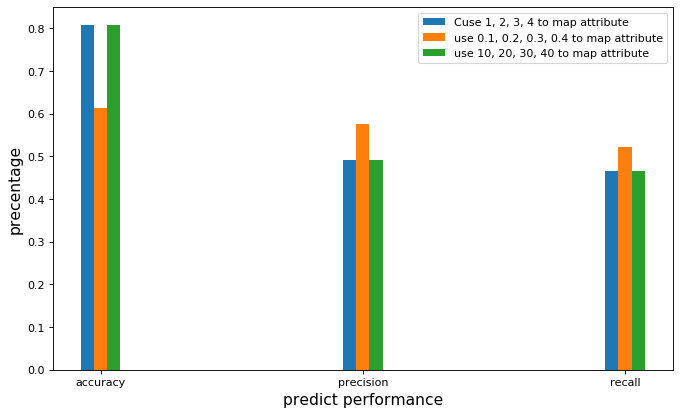

In [26]:
compare_serveral_evaluation(evaluation_single,evaluation_float, evaluation_double)

################# Car Dataset - orinal to nominal result ##################
accuracy is: 0.871528
error rate is: 0.128472

----------------the macro averaging way------------------
Marco averaging precision is:  0.8040352387146505
Marco averaging recall is: 0.6378405556688042
----------------the micro averaging way------------------
Mirco averaging precision is: 0.8715277777777778
Mirco averaging recall is: 0.8715277777777778
----------------the weight averaging way------------------
weight averaging precision is: 0.8688062641518524
weight averaging recall is: 0.8715277777777779


################# Car Dataset - orinal to numeric result ##################
accuracy is: 0.808449
error rate is: 0.191551

----------------the macro averaging way------------------
Marco averaging precision is:  0.4911436895877529
Marco averaging recall is: 0.46454782196969696
----------------the micro averaging way------------------
Mirco averaging precision is: 0.8084490740740741
Mirco averaging recall is: 

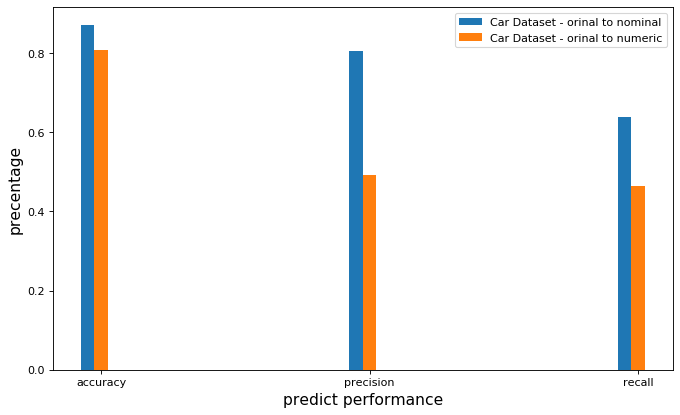

In [27]:
###4. Car Dataset - ordianl only###
####################################################################################################
filename = "datasets/car.data"
classes = ("unacc" , "acc", "good", "vgood")
#Ord2Nom也可以不带第二个参数，第二个参数只在画图的时候可以按ordinal的顺序显示
car_2nom = NB_Model(
    classes,
    Ord2NomCounter("buying", lambda x: {"vhigh":3, "high":2, "med":1, "low":0}[x]),
    Ord2NomCounter("maint", lambda x: {"vhigh":3, "high":2, "med":1, "low":0}[x]),
    Ord2NomCounter("doors", lambda x: {"5more":3, "4":2, "3":1, "2":0}[x]),
    Ord2NomCounter("persons", lambda x: {"more":2, "4":1, "2":0}[x]),
    Ord2NomCounter("lug_boot", lambda x: {"big":2, "med":1, "small":0}[x]),
    Ord2NomCounter("safety", lambda x: {"high":2, "med":1, "low":0}[x]),
    ClassCounter("Car Evaluation")
)

car_2num = NB_Model(
    classes,
    Ord2NumCounter("buying", lambda x: {"vhigh":3, "high":2, "med":1, "low":0}[x]),
    Ord2NumCounter("maint", lambda x: {"vhigh":3, "high":2, "med":1, "low":0}[x]),
    Ord2NumCounter("doors", lambda x: {"5more":3, "4":2, "3":1, "2":0}[x]),
    Ord2NumCounter("persons", lambda x: {"more":2, "4":1, "2":0}[x]),
    Ord2NumCounter("lug_boot", lambda x: {"big":2, "med":1, "small":0}[x]),
    Ord2NumCounter("safety", lambda x: {"high":2, "med":1, "low":0}[x]),
    ClassCounter("Car Evaluation")
)

with open(filename,"r") as file:
    lines = file.readlines()
    
    car_2nom.preprocess(lines)
    car_2nom.train()
    #car_2nom.draw_attr_distribution()
    result1 = car_2nom.predict(lines)
    evaluation1 = Evaluation("Car Dataset - orinal to nominal", classes, result1)
    evaluation1.evaluate()
    #evaluation1.draw_bar_chart()
    
    car_2num.preprocess(lines)
    car_2num.train()
    #car_2num.draw_attr_distribution()
    result2 = car_2num.predict(lines)
    evaluation2 = Evaluation("Car Dataset - orinal to numeric", classes, result2)
    evaluation2.evaluate()
    #evaluation2.draw_bar_chart()
    #compare_serveral_evaluation(evaluation1, evaluation2)
    
    compare_serveral_evaluation(evaluation1, evaluation2) 

################# nursery Dataset - orinal to nominal result ##################
accuracy is: 0.903009
error rate is: 0.096991

----------------the macro averaging way------------------
Marco averaging precision is:  0.7248820267369591
Marco averaging recall is: 0.5664257996860103
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9030092592592592
Mirco averaging recall is: 0.9030092592592592
----------------the weight averaging way------------------
weight averaging precision is: 0.905644265528916
weight averaging recall is: 0.9030092592592592




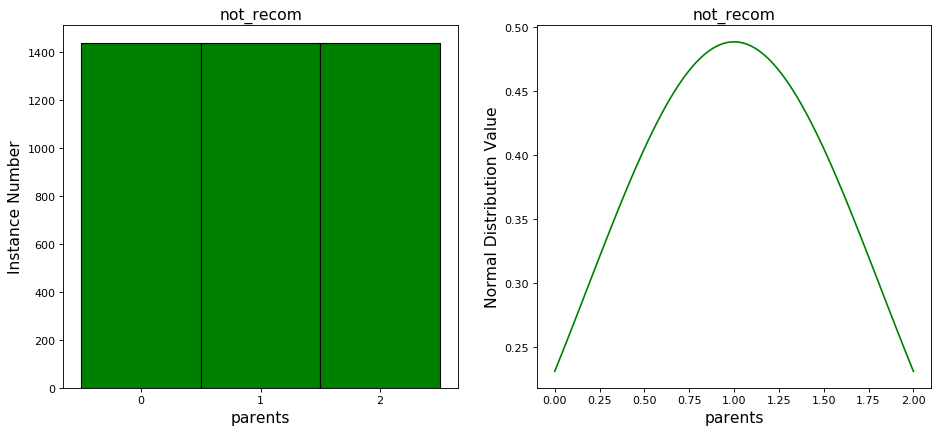

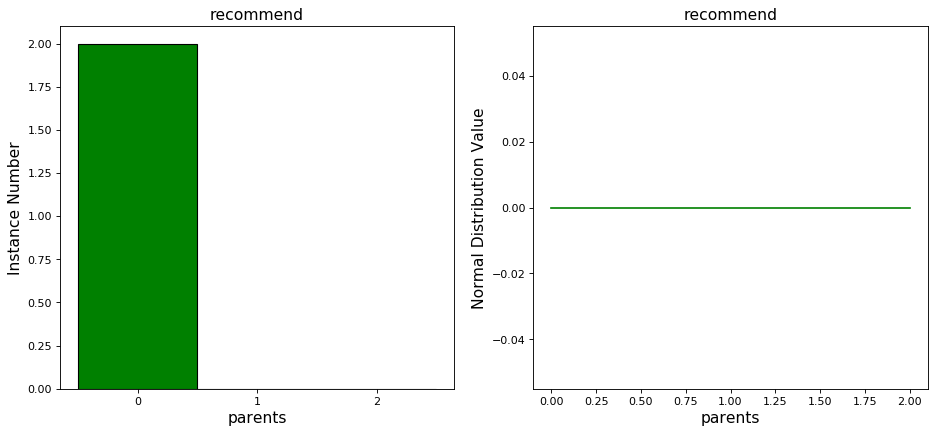

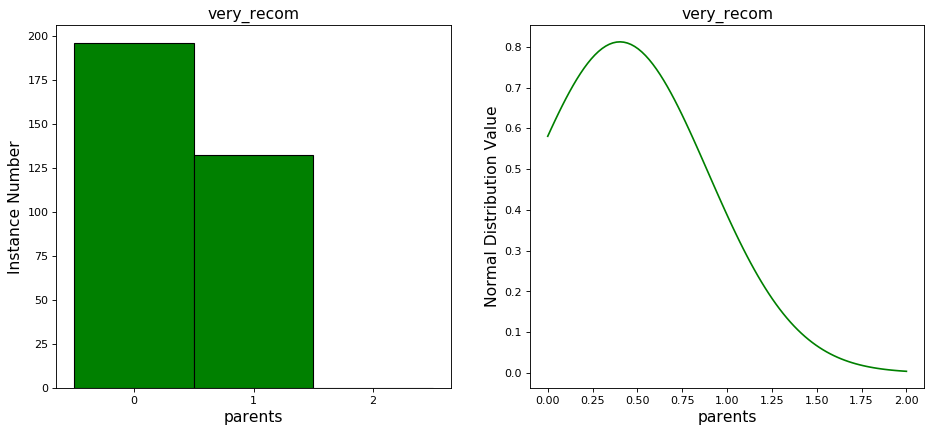

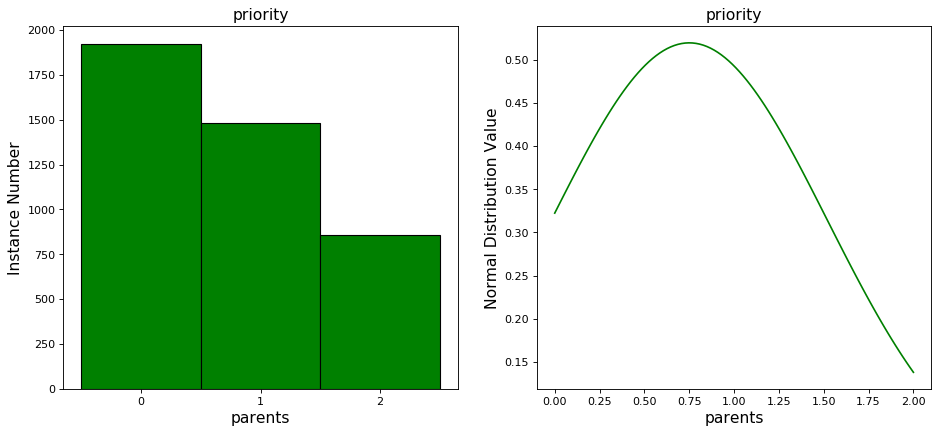

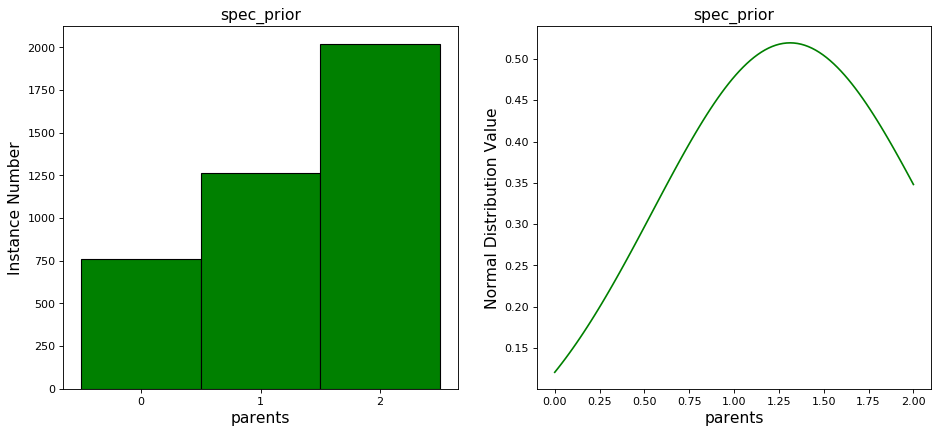

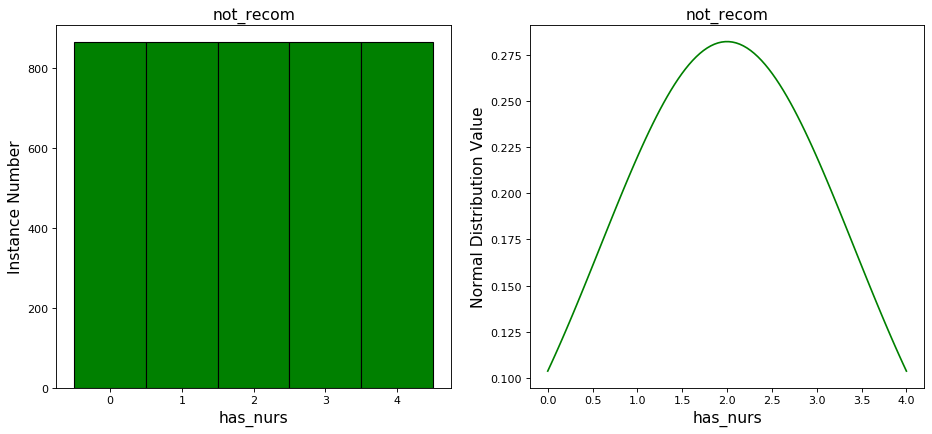

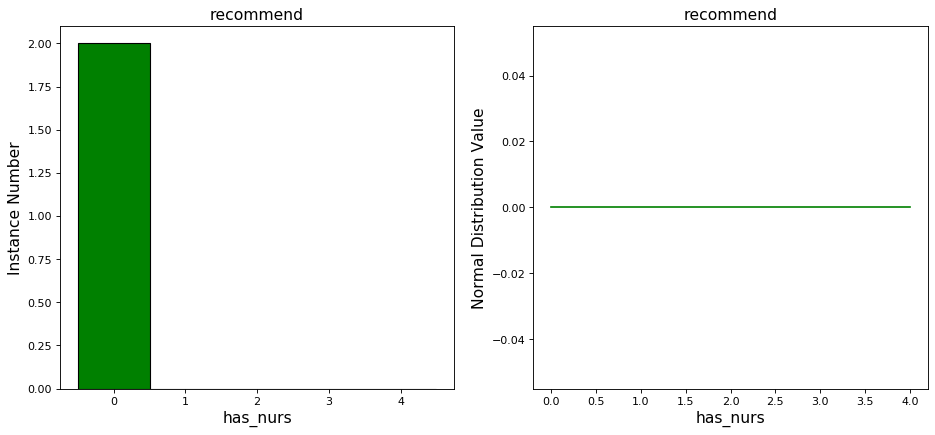

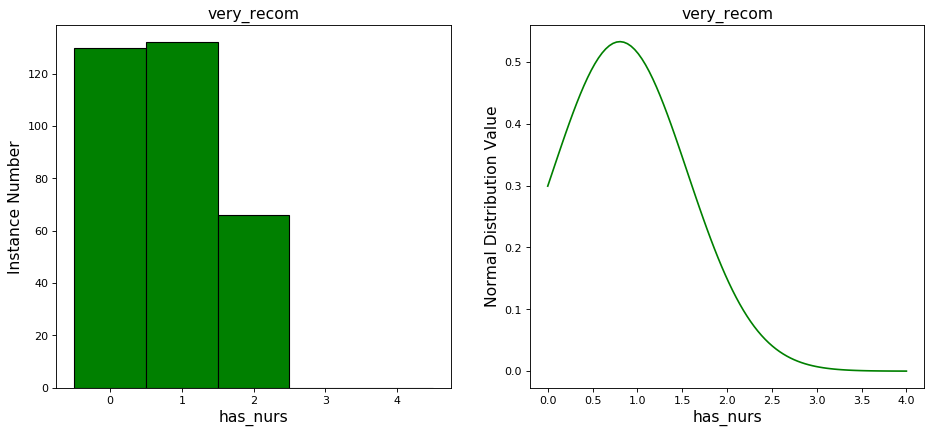

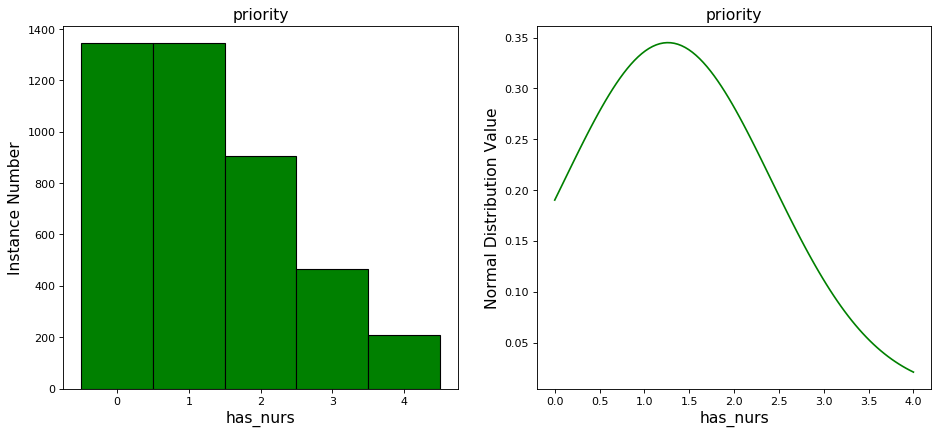

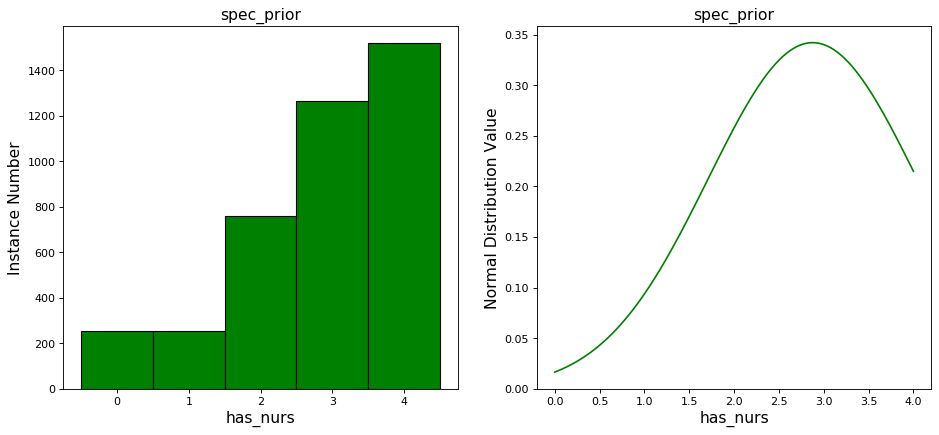

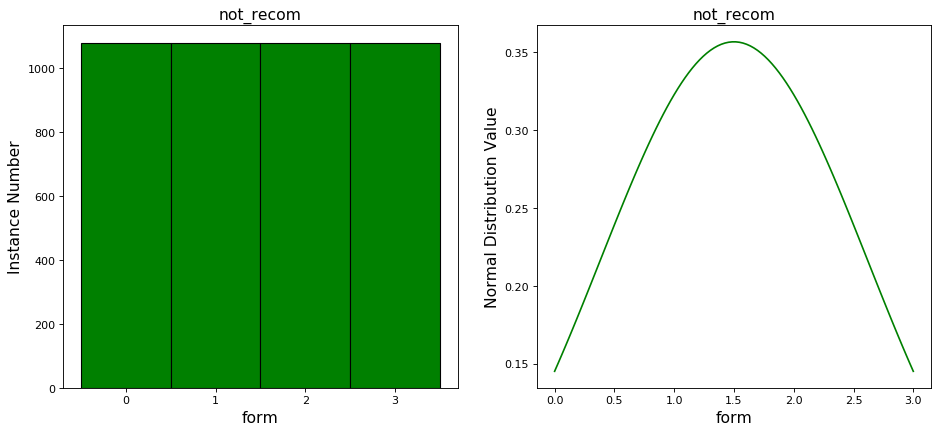

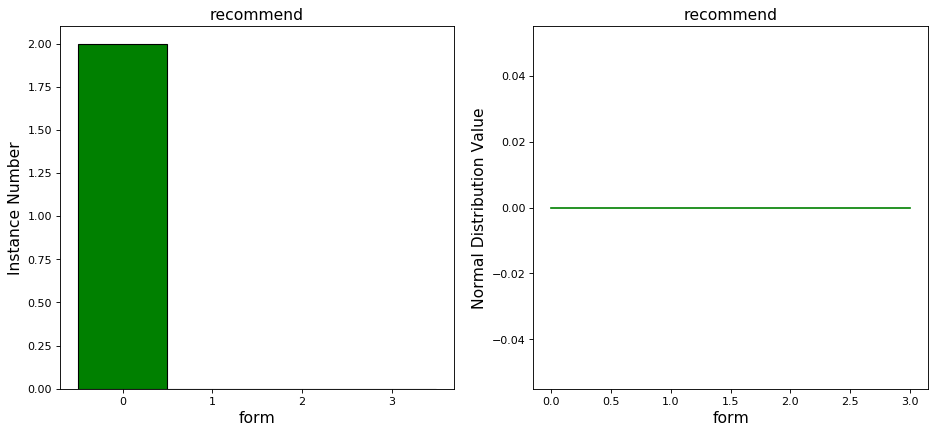

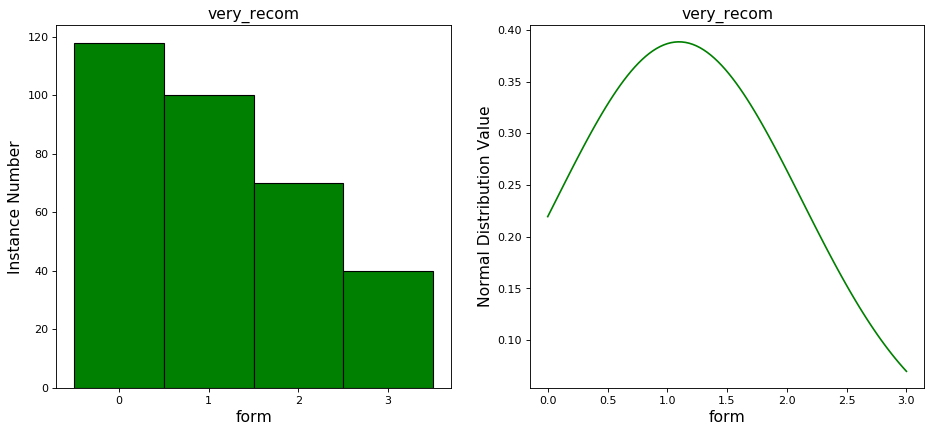

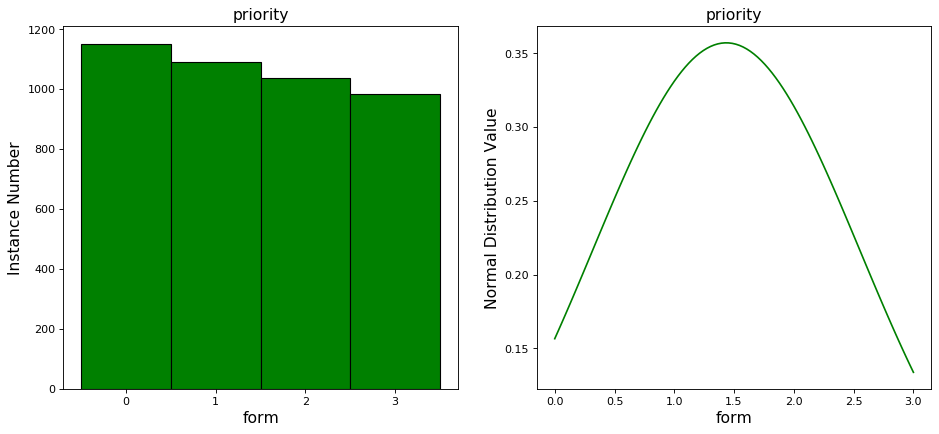

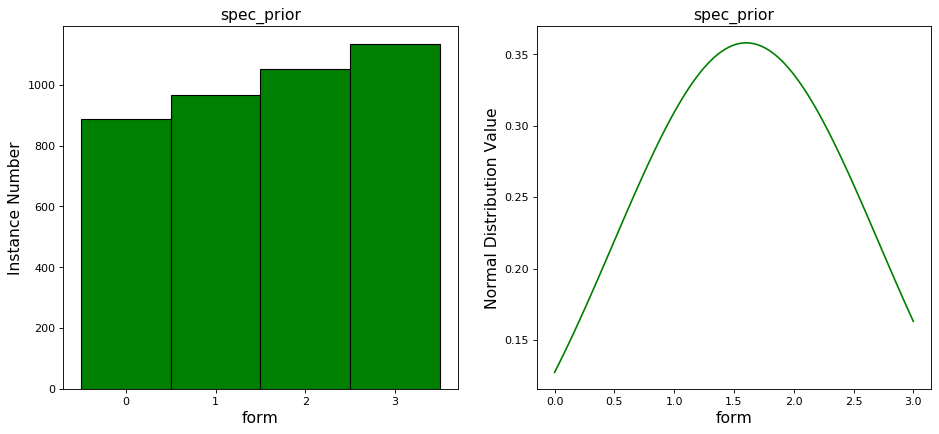

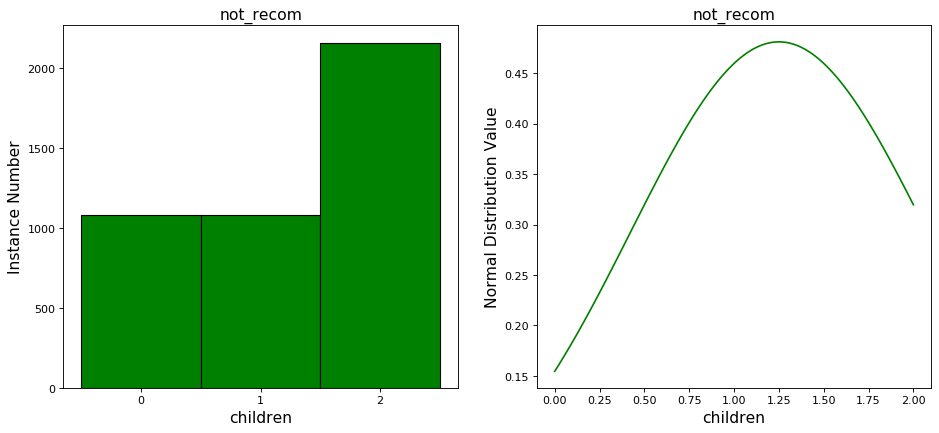

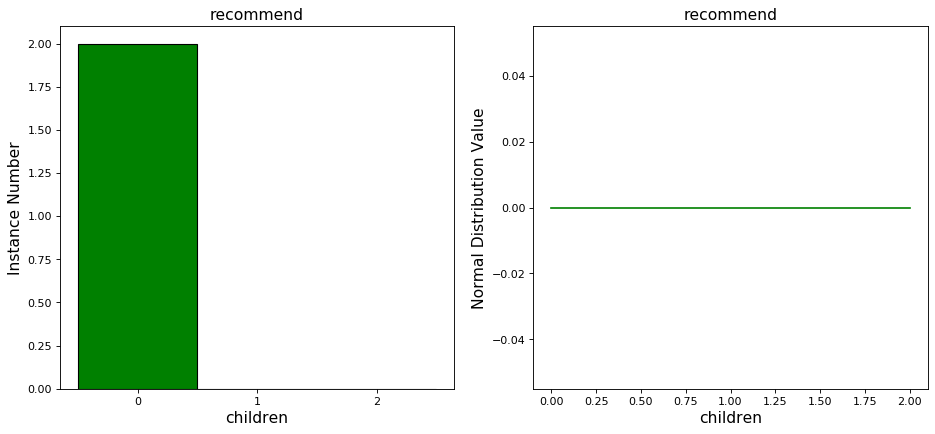

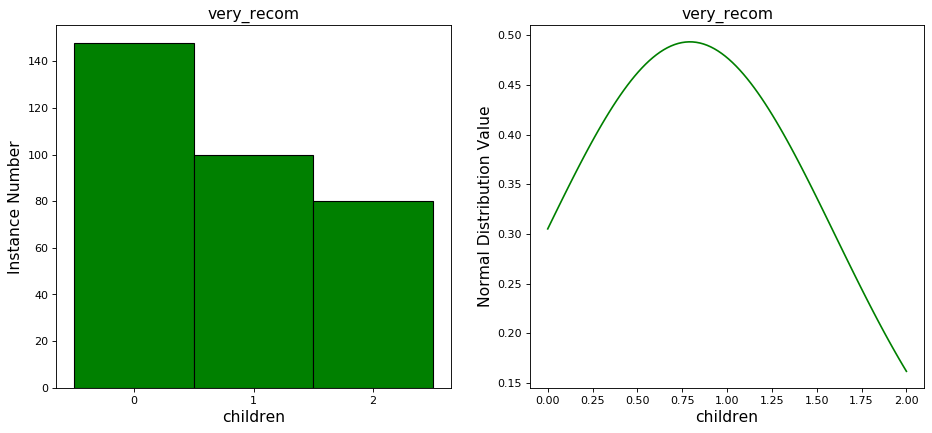

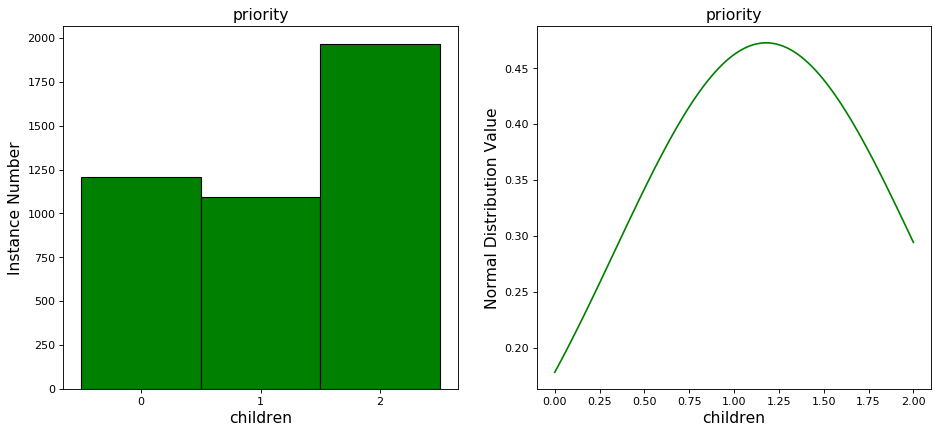

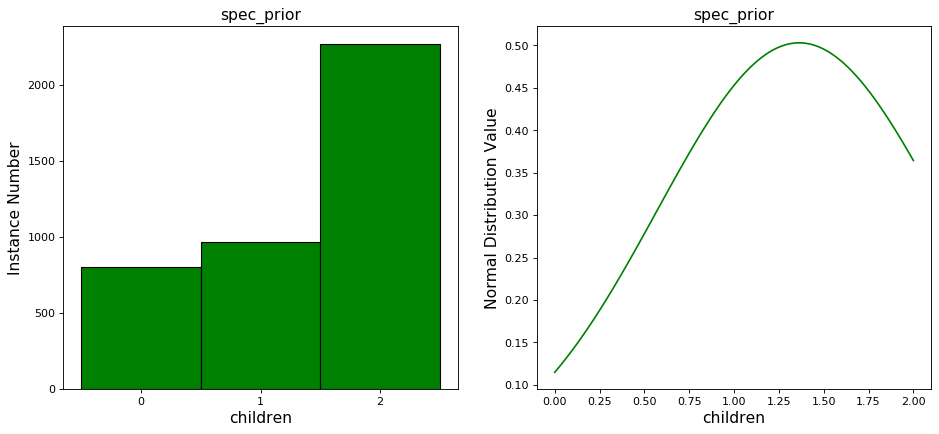

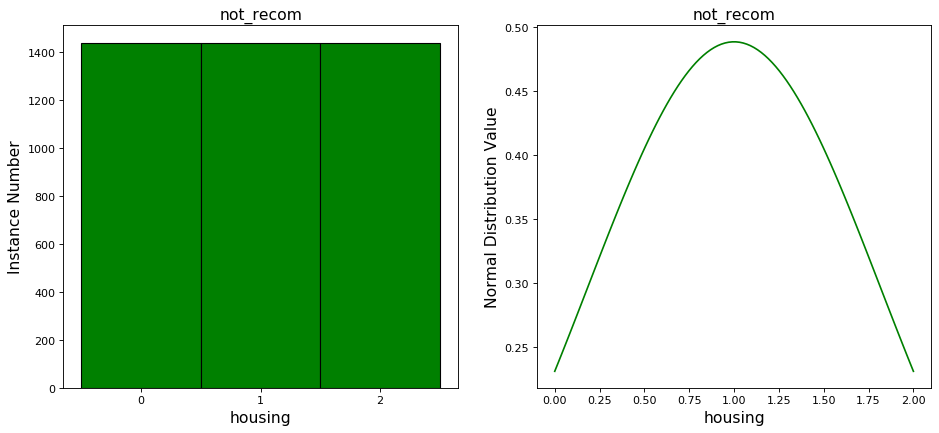

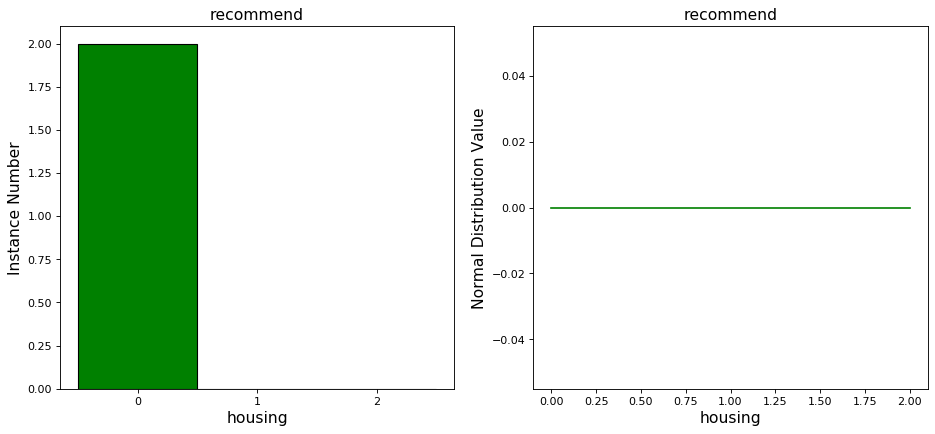

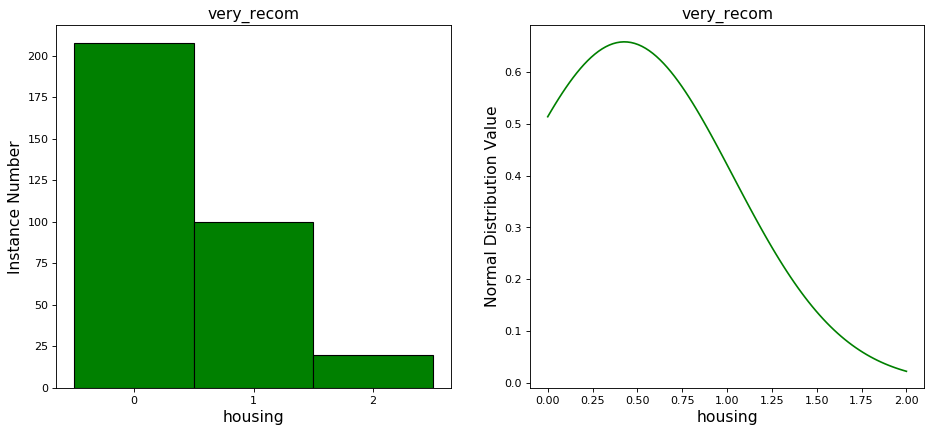

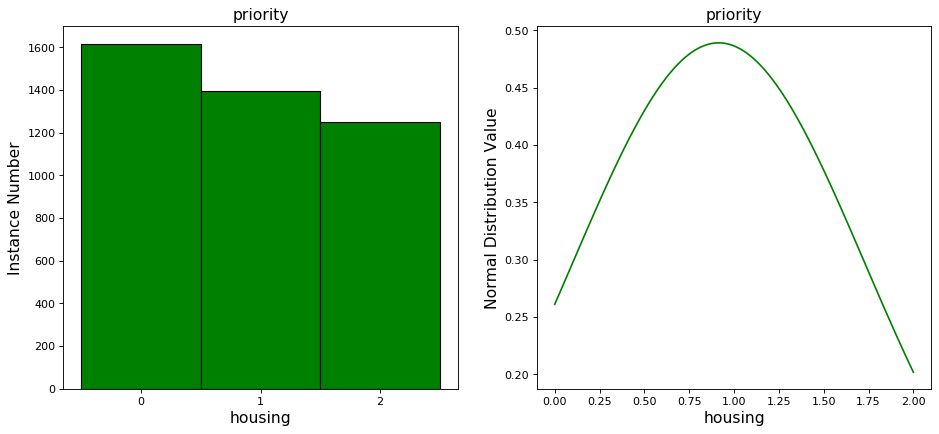

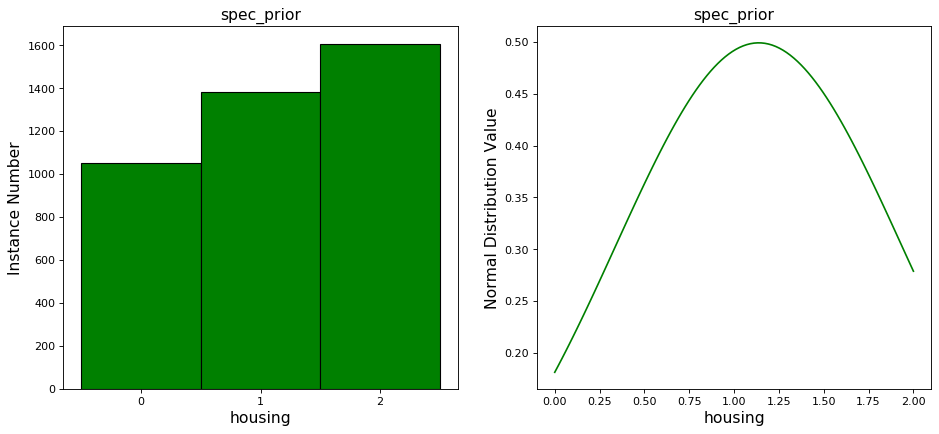

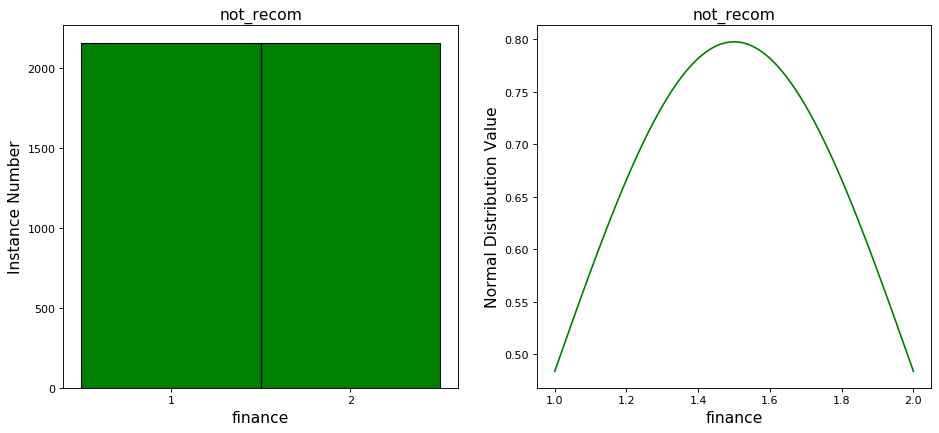

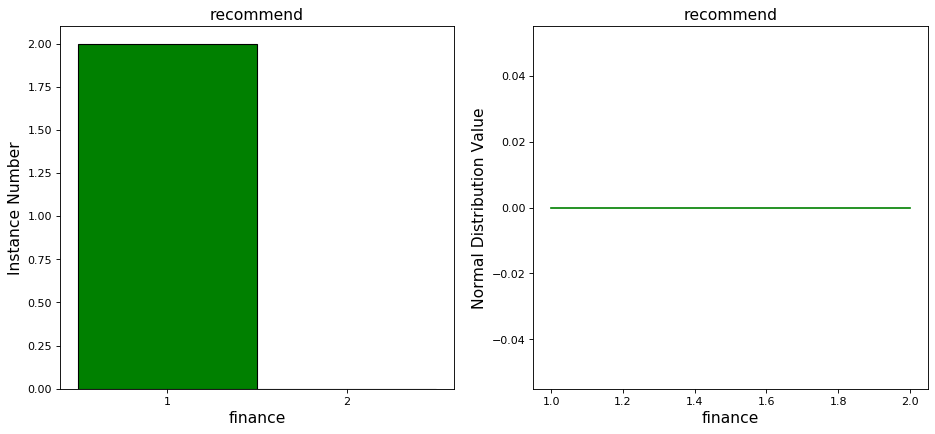

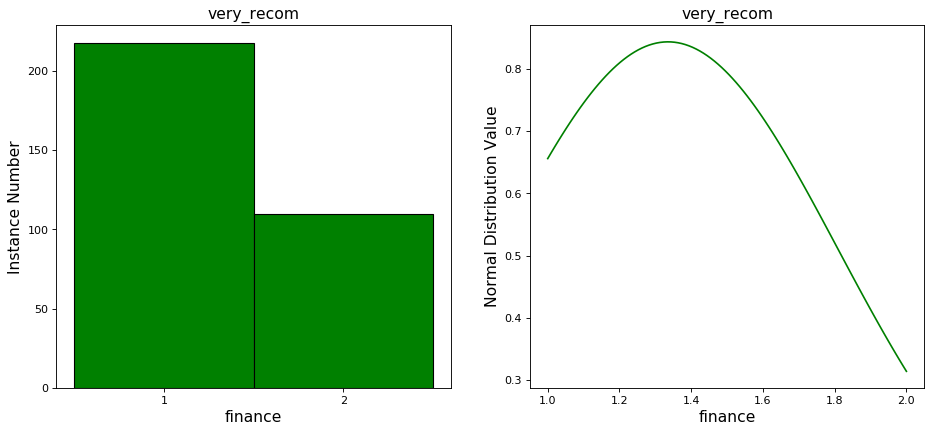

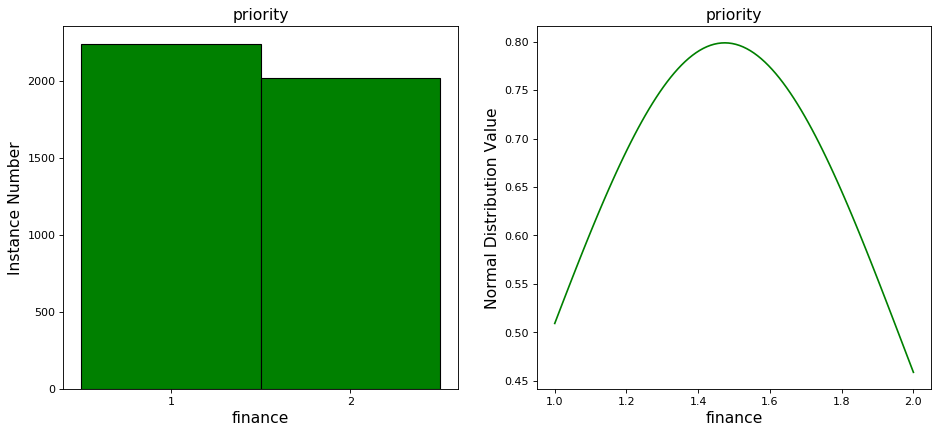

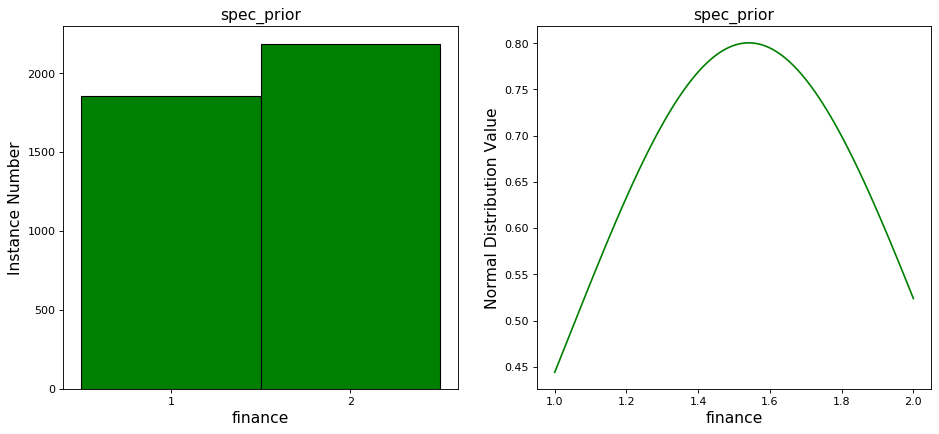

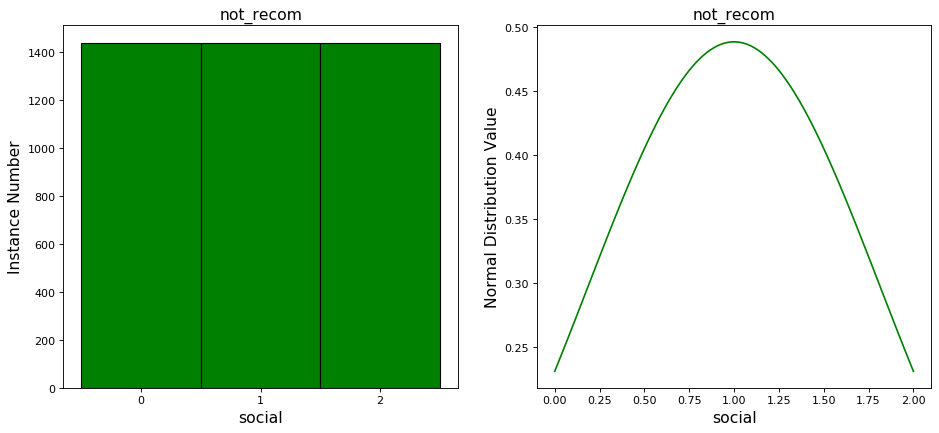

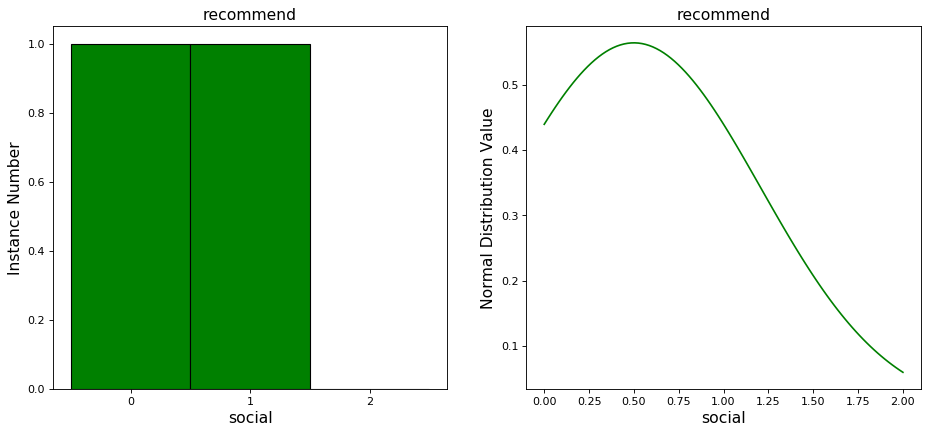

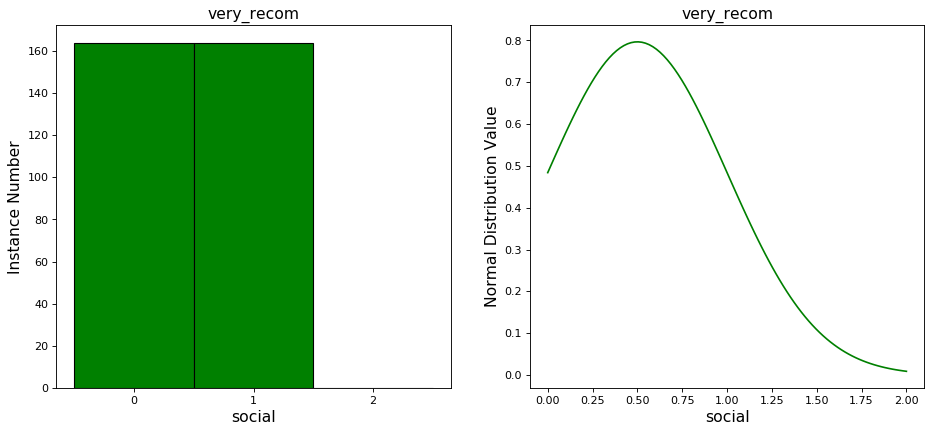

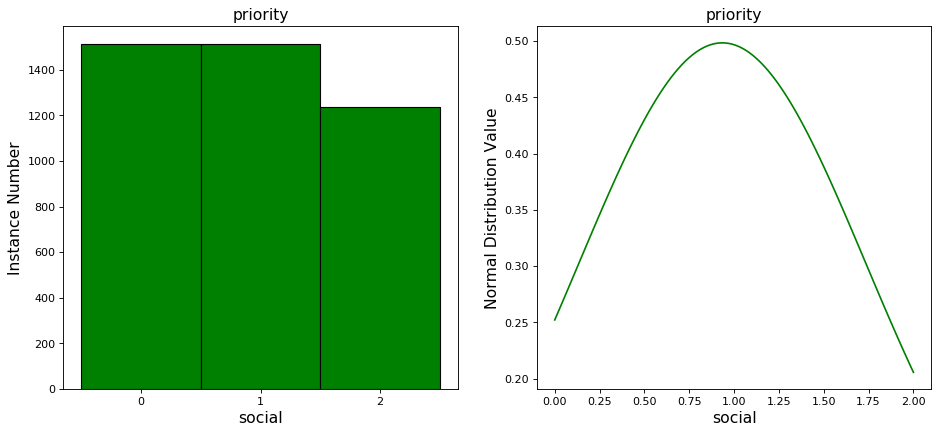

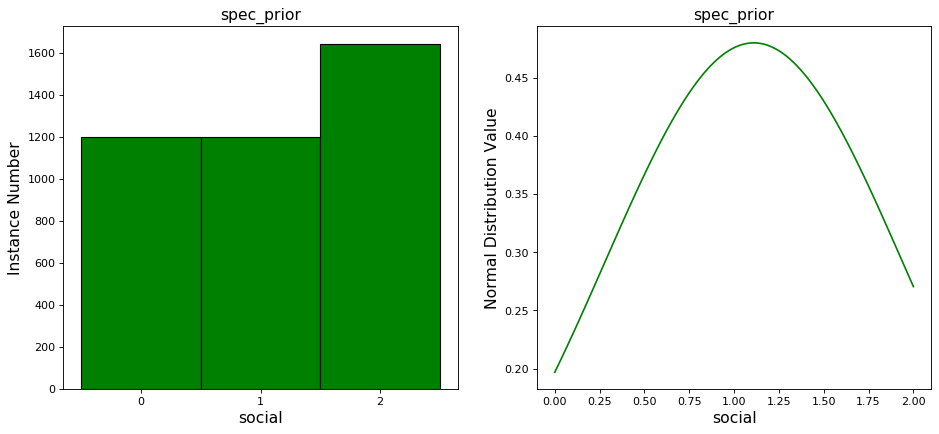

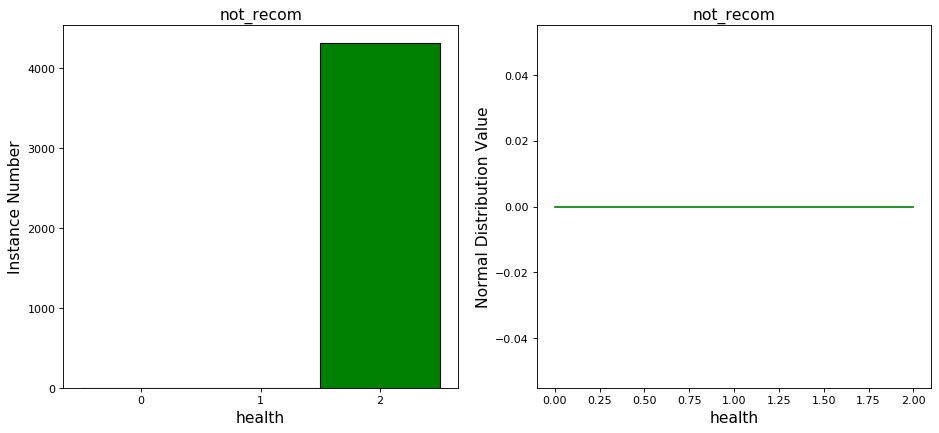

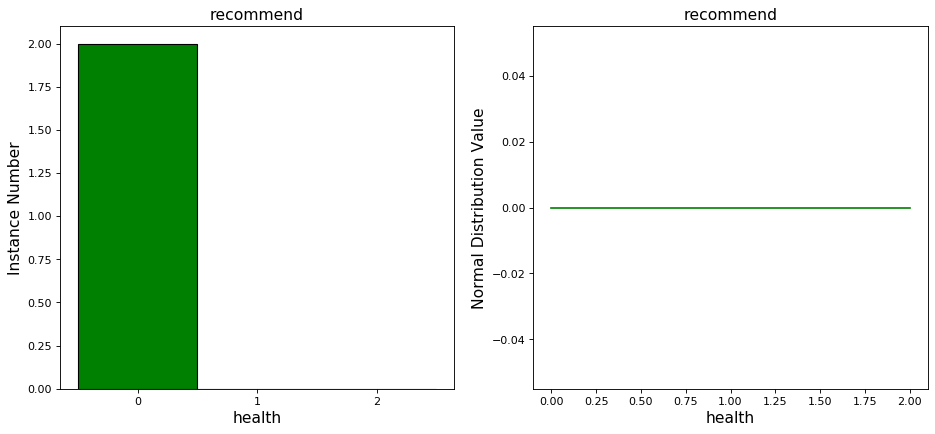

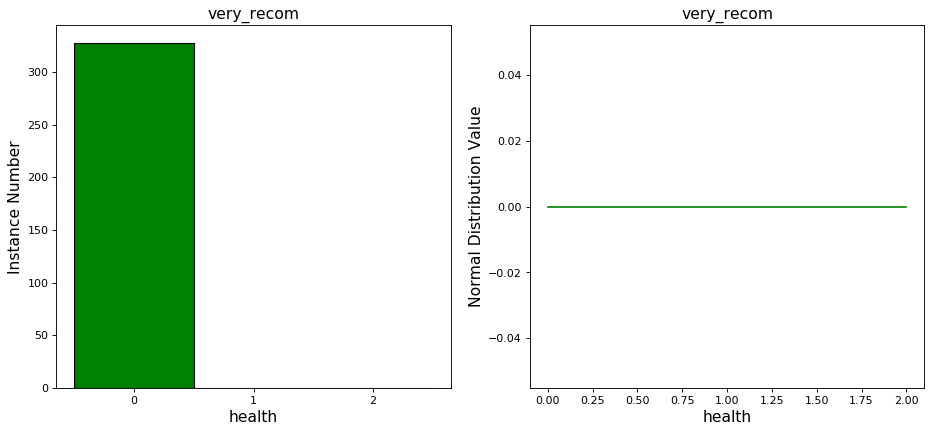

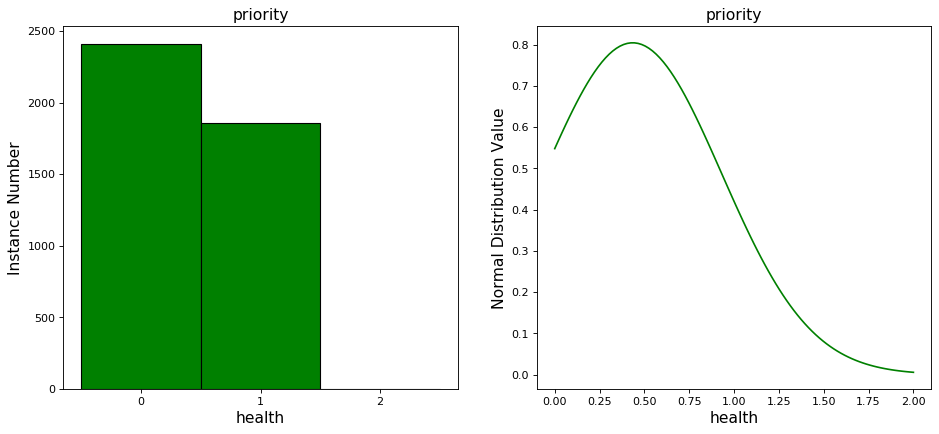

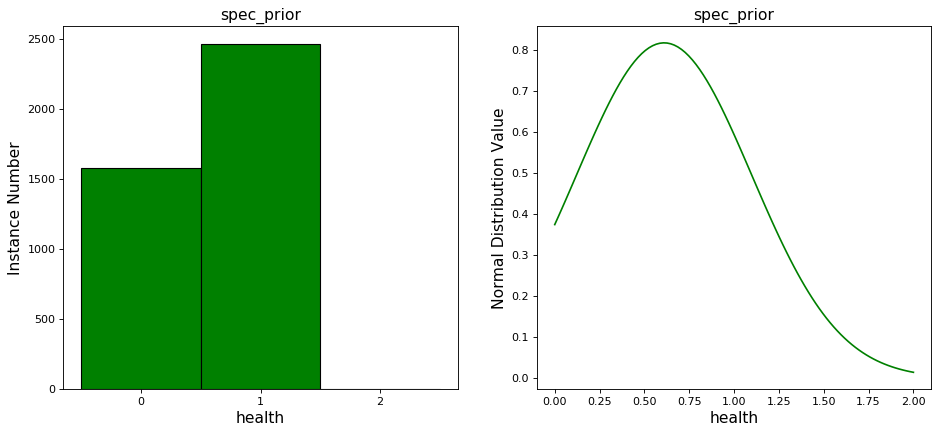

################# nursery Dataset - orinal to numeric result ##################
accuracy is: 0.568519
error rate is: 0.431481

----------------the macro averaging way------------------
Marco averaging precision is:  0.2279945946785098
Marco averaging recall is: 0.35458862498452326
----------------the micro averaging way------------------
Mirco averaging precision is: 0.5685185185185185
Mirco averaging recall is: 0.5685185185185185
----------------the weight averaging way------------------
weight averaging precision is: 0.3661649757304215
weight averaging recall is: 0.5685185185185185




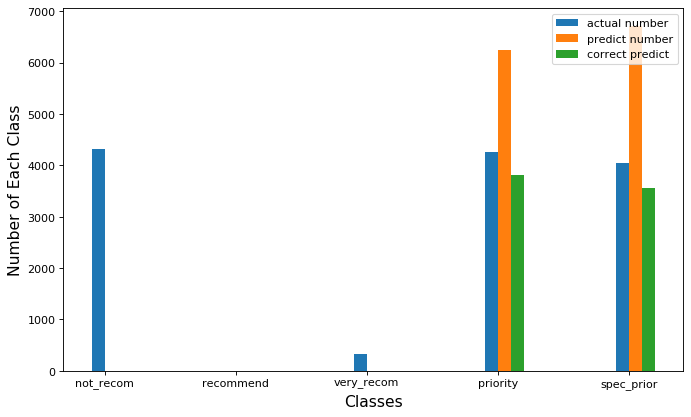

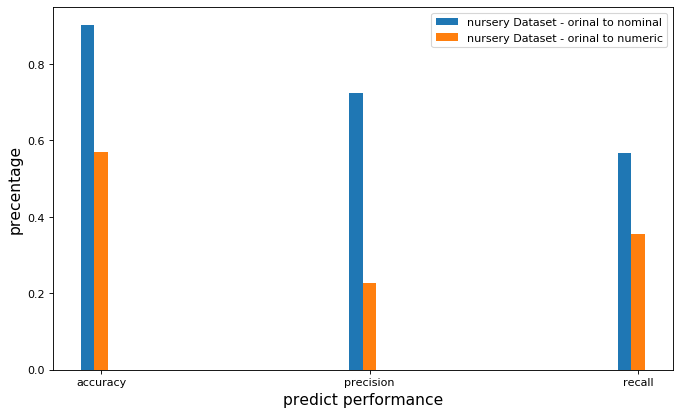

In [28]:
###7. Nursery Dataset - ordinal only###
####################################################################################################
filename = "datasets/nursery.data"
classes = ('not_recom','recommend','very_recom','priority','spec_prior')
nursery_2nom = NB_Model(
    classes,
    Ord2NomCounter('parents'),
    Ord2NomCounter('has_nurs'),
    Ord2NomCounter('form'),
    Ord2NomCounter('children'),
    Ord2NomCounter('housing'),
    Ord2NomCounter('finance'),
    Ord2NomCounter('social'),
    Ord2NomCounter('health'),
    ClassCounter('recommendation')
)

nursery_2num = NB_Model(
    classes,
    Ord2NumCounter('parents', lambda x: {"usual":0, "pretentious":1, "great_pret":2}[x]),
    Ord2NumCounter('has_nurs', lambda x: {"proper":0, "less_proper":1, "improper":2, "critical":3, "very_crit":4}[x]),
    Ord2NumCounter('form', lambda x: {"complete":0, "completed":1, "incomplete":2, "foster":3}[x]),
    Ord2NumCounter('children', lambda x: {"1":0, "2":1, "3":2, "more":2}[x]),
    Ord2NumCounter('housing', lambda x: {"convenient":0, "less_conv":1, "critical":2}[x]),
    Ord2NumCounter('finance', lambda x: {"convenient":1, "inconv":2}[x]),
    Ord2NumCounter('social', lambda x: {"nonprob":0, "slightly_prob":1, "problematic":2}[x]),
    Ord2NumCounter('health', lambda x: {"recommended":0, "priority":1, "not_recom":2}[x]),
    ClassCounter('recommendation')
)

with open(filename,"r") as file:
    lines = file.readlines()
    
    nursery_2nom.preprocess(lines)
    nursery_2nom.train()
    #nursery_2nom.draw_attr_distribution()
    result1 = nursery_2nom.predict(lines)
    evaluation1 = Evaluation("nursery Dataset - orinal to nominal", classes, result1)
    evaluation1.evaluate()
    #evaluation1.draw_bar_chart()
    
    nursery_2num.preprocess(lines)
    nursery_2num.train()
    nursery_2num.draw_attr_distribution()
    result2 = nursery_2num.predict(lines)
    evaluation2 = Evaluation("nursery Dataset - orinal to numeric", classes, result2)
    evaluation2.evaluate()
    evaluation2.draw_bar_chart()
    
    compare_serveral_evaluation(evaluation1, evaluation2)

################# somerville Dataset - orinal to nominal result ##################
accuracy is: 0.678322
error rate is: 0.321678

----------------the macro averaging way------------------
Marco averaging precision is:  0.6763241736360015
Marco averaging recall is: 0.6742424242424243
----------------the micro averaging way------------------
Mirco averaging precision is: 0.6783216783216783
Mirco averaging recall is: 0.6783216783216783
----------------the weight averaging way------------------
weight averaging precision is: 0.6774806237171829
weight averaging recall is: 0.6783216783216783


################# somerville Dataset - orinal to numeric result ##################
accuracy is: 0.608392
error rate is: 0.391608

----------------the macro averaging way------------------
Marco averaging precision is:  0.6052850603412401
Marco averaging recall is: 0.5995670995670996
----------------the micro averaging way------------------
Mirco averaging precision is: 0.6083916083916084
Mirco averagin

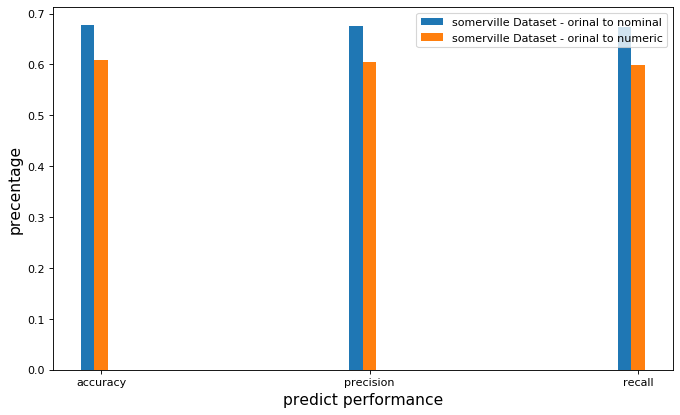

In [29]:
###8. somerville Dataset - ordinal only###
####################################################################################################
filename = "datasets/somerville.data"
classes = ('0', '1')
somerville_2nom = NB_Model(
    classes,
    ClassCounter('Decision'),
    Ord2NomCounter('X1',int),
    Ord2NomCounter('X2',int),
    Ord2NomCounter('X3',int),
    Ord2NomCounter('X4',int),
    Ord2NomCounter('X5',int),
    Ord2NomCounter('X6',int)
)

somerville_2num = NB_Model(
    classes,
    ClassCounter('Decision'),
    Ord2NumCounter('X1',int),
    Ord2NumCounter('X2',int),
    Ord2NumCounter('X3',int),
    Ord2NumCounter('X4',int),
    Ord2NumCounter('X5',int),
    Ord2NumCounter('X6',int)
)

with open(filename,"r") as file:
    lines = file.readlines()
    
    somerville_2nom.preprocess(lines)
    somerville_2nom.train()
    #somerville_2nom.draw_attr_distribution()
    result1 = somerville_2nom.predict(lines)
    evaluation1 = Evaluation("somerville Dataset - orinal to nominal", classes, result1)
    evaluation1.evaluate()
    #evaluation1.draw_bar_chart()
    
    somerville_2num.preprocess(lines)
    somerville_2num.train()
    #somerville_2num.draw_attr_distribution()
    result2 = somerville_2num.predict(lines)
    evaluation2 = Evaluation("somerville Dataset - orinal to numeric", classes, result2)
    evaluation2.evaluate()
    #evaluation2.draw_bar_chart()
    
    compare_serveral_evaluation(evaluation1, evaluation2)

### Q4
Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy (you should implement this yourself and do not simply call existing implementations from `scikit-learn`). How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)

### Q5
Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the na¨ıve Bayes classifier? Explain why, or why not.

### Q6
The Gaussian na¨ıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in these datasets? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the NB classifier’s predictions.

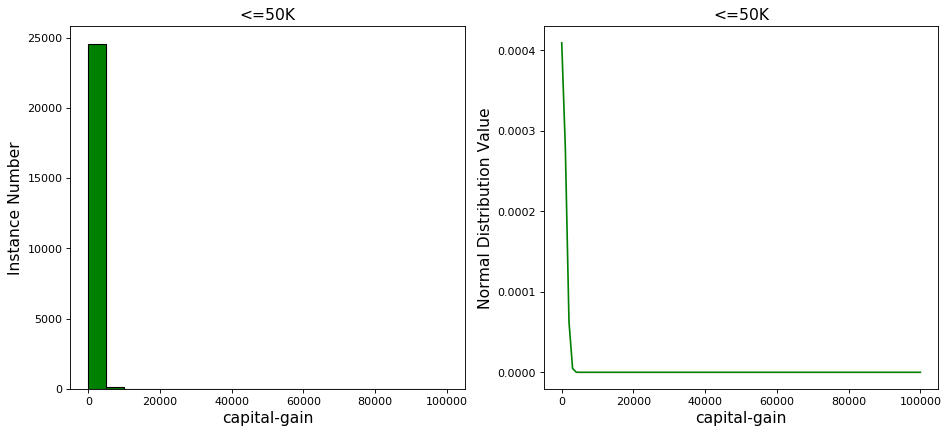

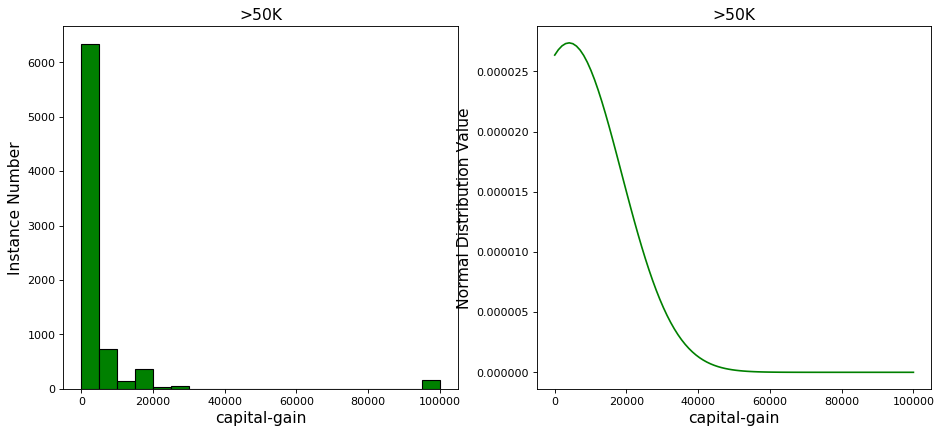

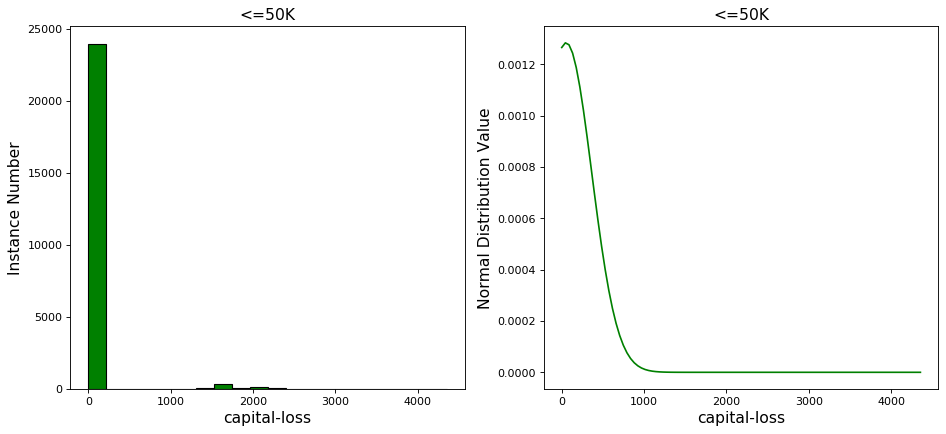

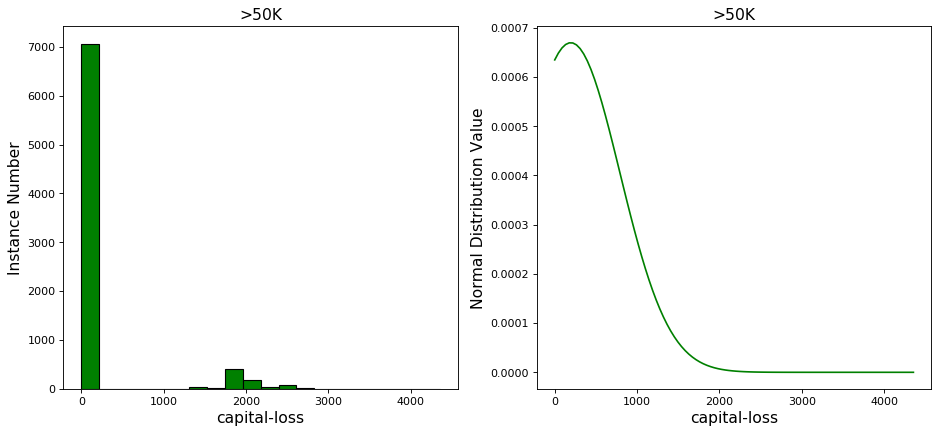

In [30]:
#### Find attributes that violate Gaussian asumption ####
#########################################################
filename = "datasets/adult.data"
classes = ("<=50K" , ">50K")
adult = NB_Model(
    classes,
    NumCounter("age"),
    NomCounter("workclass"),
    NumCounter("fnlwgt"),
    Ord2NomCounter("education"),
    Ord2NomCounter("education-num"),
    NomCounter("marital-status"),
    NomCounter("occupation"),
    NomCounter("relationship"),
    NomCounter("race"),
    NomCounter("sex"),
    NumCounter("capital-gain"),
    NumCounter("capital-loss"),
    NumCounter("hours-per-week"),
    NomCounter("native-country"),
    ClassCounter("salary")
)
adult.set_filters("?")

with open(filename,"r") as file:
    lines = file.readlines()
    
    adult.preprocess(lines)
    adult.train()
    adult.draw_attr_distribution('capital-gain')
    adult.draw_attr_distribution('capital-loss')
